In [1]:
## widen the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

/tmp/ipykernel_941363/2147804149.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from collections import defaultdict
from tqdm import tqdm

%matplotlib inline

In [3]:
def shermanMorrison(V:np.ndarray, x:np.ndarray):
    """
    ${V_t}^{-1} = V_{t-1}^{-1} - \frac{V_{t-1}^{-1}xx^T V_{t-1}^{-1}}{1 + x^T V_{t-1}^{-1} x}$
    V: inverse of old gram matrix, corresponding to $V_{t-1}$.
    x: a new observed context
    return: inverse of new gram matrix
    """
    numerator = np.einsum("ij, j, k, kl -> il", V, x, x, V)
    denominator = (1 + np.einsum("i, ij, j ->", x, V, x))
    return V - (numerator / denominator)


def l2norm(v:np.ndarray):
    v = v.flatten()
    return np.sqrt(np.sum(v ** 2))


def matrix_norm(m:np.ndarray, frobenius:bool):
    assert len(m.shape) == 2
    if frobenius:
        ## frobenius norm
        return np.linalg.norm(m)
    ## spectral norm
    return np.linalg.norm(m, 2)


def covariance_generator(d:int, distribution:str="gaussian", bound:float=None):
    if distribution == "gaussian":
        rnd = np.random.randn(d, d)
    elif distribution == "uniform":
        rnd = np.random.uniform(-1, 1, size=d*d).reshape(d, d)
    
    ## make a symmetric matrix
    sym = (rnd + rnd.T) / 2
    ## make positive semi-definite and bound its maximum singular value
    mat = sym @ sym.T
    
    if bound is not None:
        mat *= (bound / np.linalg.norm(mat, 2))
    
    return mat


# Function for Gram-Schmidt process
def gram_schmidt(A):
    Q = np.zeros(A.shape)
    for i in range(A.shape[1]):
        # Orthogonalize the vector
        Q[:,i] = A[:,i]
        for j in range(i):
            Q[:,i] -= np.dot(Q[:,j], A[:,i]) * Q[:,j]
        
        # Normalize the vector
        Q[:,i] = Q[:,i] / np.linalg.norm(Q[:,i])
    return Q


def make_diagonal(v):
    dim, = v.shape
    diag = np.zeros((dim, dim))
    for i in range(dim):
        diag[i, i] = v[i]
    return diag


def positive_definite_generator(dimension:int, distribution:str="uniform"):
    d = dimension
    ## create orthogonal eigenvectors
    source = np.random.uniform(-1, 1, size=(d*d)).reshape(d, d)
    eigvecs = gram_schmidt(source)
    
    ## create a matrix of eigenvalues
    eigvals = np.random.uniform(0, 1, size=d)
    eigmat = make_diagonal(np.absolute(eigvals))
    
    ## make the targeted positive definite matrix
    Z = source @ eigmat @ source.T
    return Z


def minmax(v:np.ndarray, bound:float=1.):
    min = np.min(v)
    max = np.max(v)
    return ((v - min) / (max - min)) * bound


def left_pseudo_inverse(A:np.ndarray):
    d, k = A.shape
    u, A_sig, v_T = np.linalg.svd(A)
    
    B_sig = np.zeros((k, d))
    for i in range(k):
        B_sig[i, i] = 1 / A_sig[i]
    
    B = v_T.T @ B_sig @ u.T
    
    return B


def rademacher(size:int):
    """
    Generate Rademacher random variables.

    Args:
    size (int): Number of random variables to generate.

    Returns:
    numpy.ndarray: An array of Rademacher random variables.
    """
    return 2 * np.random.randint(0, 2, size) - 1


def subgaussian_noise(distribution:str, size:int, std:float=None):
    """
    distribution (str): the distribution to sample a sub-Gaussian noise
    size (int): The number of total rounds (T)
    std (float): The variance proxy of the noise
    """
    if not std:
        assert distribution in ["gaussian", "uniform"]
    
    if distribution == "gaussian":
        if not std:
            std = 1
        noise = np.random.normal(loc=0, scale=std, size=size) 
    elif distribution == "uniform":
        if not std:
            low = -1
            high = 1
            std = np.sqrt(((high - low) ** 2) / 12)
        else:
            low = -np.sqrt(3) * std
            high = np.sqrt(3) * std
        noise = np.random.uniform(low=low, high=high, size=size)
    else:
        std = 1
        noise = rademacher(size=size)
    return noise, std

In [4]:
def feature_sampler(dimension:int, feat_dist:str, size:int, disjoint:bool, cov_dist:str=None, bound:float=None):
    assert feat_dist.lower() in ["gaussian", "uniform"]
    
#     np.random.seed(random_state)
    
    if disjoint:
        if feat_dist.lower() == "gaussian":
            ## gaussian
            feat = np.random.multivariate_normal(mean=np.zeros(dimension), cov=np.identity(dimension), size=size)
        else:
            ## uniform
            feat = np.random.uniform(low=-1., high=1., size=size*dimension).reshape(size, dimension)
    else:
        assert cov_dist is not None
        if feat_dist.lower() == "gaussian":
            ## gaussian
            cov = covariance_generator(dimension, distribution=cov_dist)
            feat = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov, size=size)
        else:
            ## uniform
            # Cholesky decomposition
            pd = positive_definite_generator(dimension, distribution=cov_dist)
            L = np.linalg.cholesky(pd)
            feat = np.random.uniform(low=-1., high=1., size=size*dimension).reshape(size, dimension)
            feat = L @ feat
            
    if bound is not None:
        ## bound the L2 norm of each row vector
        for i in range(size):
            row = feat[i, :]
            norm = l2norm(row)
            row *= (bound / norm)
            feat[i, :] = row
    
    return feat


def mapping_generator(d_in:int, d_out:int, distribution:str, bound:float=None):
    assert distribution.lower() in ["gaussian", "uniform"]
    
#     np.random.seed(random_state)
    
    if distribution.lower() == "gaussian":
        mat =  np.random.randn(d_in, d_out)
    else:
        mat = np.random.uniform(low=-0.5, high=0.5, size=d_in*d_out).reshape(d_in, d_out)
        
    if bound:
        max_singular = np.linalg.norm(mat, 2)
        mat *= (bound / max_singular)
    return mat


def param_generator(dimension:int, distribution:str, disjoint:bool, bound:float=None):
    assert distribution.lower() in ["gaussian", "uniform"]
    
#     np.random.seed(random_state)
    
    if disjoint:
        if distribution == "gaussian":
            param = np.random.randn(dimension)
        else:
            param = np.random.uniform(low=0., high=1., size=dimension)
    else:
        if distribution == "gaussian":
            cov = covariance_generator(dimension, distribution=distribution)
            param = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov)
        else:
            # uniform
            pd = positive_definite_generator(dimension, distribution=distribution)
            param = np.random.uniform(low=0., high=1., size=dimension)
            L = np.linalg.cholesky(pd)
            param = L @ param
        
    if bound:
        norm = l2norm(param)
        param *= (bound / norm)
    
    return param

In [5]:
## Agent
class ContextualBandit(ABC):
    @abstractmethod
    def choose(self, x): pass
    
    @abstractmethod
    def update(self, x, r): pass

In [6]:
class LinUCB(ContextualBandit):
    def __init__(self, d, alpha, lbda=1.):
        self.d = d
        self.alpha = alpha
        self.t = 0
        self.xty = np.zeros(d)
        self.Vinv = (1 / lbda) * np.identity(d)
        
    def choose(self, x):
        # x: action set at each round (N, d)
        self.t += 1
        
        ## compute the ridge estimator
        theta_hat = self.Vinv @ self.xty
        
        ## observe the context
        N, d = x.shape
        
        ## compute the ucb scores for each arm
        expected = x @ theta_hat # (N, ) theta_T @ x_t
        width = np.sqrt(np.einsum("Ni, ij, Nj -> N", x, self.Vinv, x) * np.log(self.t)) # (N, ) widths
        ucb_scores = expected + (self.alpha * width) # (N, ) ucb score
        
        ## chose the argmax the ucb score
        maximum = np.max(ucb_scores)
        argmax, = np.where(ucb_scores == maximum)
        
        return np.random.choice(argmax)
    
    def update(self, x, r):
        # x: context of the chosen action (d, )
        self.Vinv = shermanMorrison(self.Vinv, x)
        self.xty += (r * x)

In [7]:
def run(agent:LinUCB, num_actions:int, horizon:int, observables:np.ndarray, latents:np.ndarray, rewards:np.ndarray, 
        params:np.ndarray, reward_bound:float=None, use_tqdm:bool=True, verbose:bool=False):
    if use_tqdm:
        bar = tqdm(range(horizon))
    else:
        bar = range(horizon)
        
    regrets = np.zeros(horizon)
    
    action_space_size, obs_dim = observables.shape
    _, latent_dim = latents.shape
    
    assert num_actions <= action_space_size
    
    for t in bar:
        ## choose action set for each round
        if action_space_size == num_actions:
            action_set, reward_set, latent_set = observables, rewards, latents
        else:
            indices = np.random.randint(0, action_space_size, num_actions)
            action_set, reward_set, latent_set = observables[indices], rewards[indices], latents[indices]
        
        ## compute the expected rewards and the optimal action
        if reward_bound is None:
            exp_rewards = action_set @ params       # (num_actions, k) @ (k, ) -> (num_actions, )
        else:
            exp_rewards = minmax(action_set @ params, bound=reward_bound)
        
        optimal_action = np.argmax(exp_rewards) # index of the optimal action
        optimal_reward = exp_rewards[optimal_action]
        
        ## choose the best action
        chosen_arm = agent.choose(action_set)  # index of the chosen action
        chosen_context = action_set[chosen_arm]
        chosen_reward = rewards[chosen_arm]
        
        ## compute the instance regret
        instance_regret = optimal_reward - exp_rewards[chosen_arm]
        regrets[t] = instance_regret
        
        ## update the model
        agent.update(chosen_context, chosen_reward)

        if verbose: 
            print(f"round {t+1}, optimal action : {optimal_action}, optimal reward : {optimal_reward:.3f}, chosen action : {chosen_arm}")
            print(f"\trealized reward : {chosen_reward:.3f}, expected reward: {exp_rewards[chosen_arm]:.3f}")
            print(f"\tinstance regret : {instance_regret:.3f}, cumulative regret : {np.sum(regrets):.3f}")
        
    return regrets

# $A : Z \to X, Z\in\mathbb{R}^{k}, X\in\mathbb{R}^d$ is specified

```python
def feature_sampler(dimension:int, feat_dist:str, size:int, disjoint:bool, cov_dist:str=None, bound:float=None, random_state=1)
def mapping_generator(d_in:int, d_out:int, distribution:str, random_state=1)
def param_generator(dimension:int, distribution:str, disjoint:bool, bound:float=None, random_state=1)
def subgaussian_noise(distribution:str, size:int, std:float=None)
```

In [8]:
## hyper-parameters
M = 50000         # number of samples
N = 20            # number of actions in the action set at each round
d = 10            # observable dimension
k = 7             # latent dimension
T = 20000         # total time horizon

feature_bound = 1.
# matrix_lower_bound = 0.5  # lower bound of the decoder (inverse is the upper bound of the encoder)
matrix_bound = 1.
param_bound = 1.
reward_bound = 1.

ALPHAS = [0.0, 0.1, 0.3, 0.5, 1.0, 3.0]
run_time = 4

## $Z \sim N(0, I_k), A={(a_{ij})}_{i\in [k], j\in[d]} \sim U\left(-\frac{1}{2}, \frac{1}{2}\right), \mu_i\in \boldsymbol{\mu_*}\sim U(0, 1)$

In [9]:
## Feature generation
seed = None

## latent feature
Z = feature_sampler(dimension=k, feat_dist="gaussian", size=M, disjoint=True, bound=feature_bound)

## decoder mapping from A: Z (N, k) -> X (N, d)
# therefore A.shape = (k, d)
A = mapping_generator(d_in=k, d_out=d, distribution="uniform", bound=matrix_bound)

## Checking
print(f"Shape of latent features: {Z.shape}\nFirst latent feature: {Z[0, :]}")
print(f"Shape of the decoder: {A.shape}")

Shape of latent features: (50000, 7)
First latent feature: [ 0.21171005  0.5928736   0.38926928  0.08183762 -0.61910609 -0.08616253
 -0.23395608]
Shape of the decoder: (7, 10)


## $\sigma_{\eta} = \frac{1}{\sqrt{T}}, \eta_a^i\in\boldsymbol{\eta_a} \sim N\left(0, \sigma_\eta^2\right)$

In [10]:
context_noise, std = subgaussian_noise(distribution="gaussian", size=M*d, std=0)
context_noise = context_noise.reshape(M, d)
print(f"Shape of context noise: {context_noise.shape}")
print(f"First context noise: {context_noise[0, :]}")

Shape of context noise: (50000, 10)
First context noise: [-3.26295564  0.95236016 -0.23326278 -0.38313737 -0.69556876 -1.05761319
 -0.02640809  1.42103786  0.03321603 -0.62248687]


In [11]:
## Generate X
X = Z @ A + context_noise

for i in range(X.shape[0]):
    row = X[i, :]
    norm = l2norm(row)
    row *= (feature_bound / norm)
    X[i, :] = row

print(f"Shape of observable features: {X.shape}")
print(f"Observable features of the first arm: {X[0, :]}")
print(f"Maximum L2 norm of the observable features: {np.max([l2norm(X[i, :]) for i in range(M)])}")

Shape of observable features: (50000, 10)
Observable features of the first arm: [-0.84138423  0.18854833 -0.06870002 -0.1514345  -0.16392854 -0.29843246
 -0.0150665   0.27609239  0.09662274 -0.16475903]
Maximum L2 norm of the observable features: 1.0000000000000002


### $\epsilon\sim N\left(0, \sigma_\epsilon^2\right), \sigma_\epsilon=0.1$

In [12]:
## reward parameter
true_param = param_generator(dimension=k, distribution="uniform", disjoint=True, bound=param_bound)
print(f"True reward parameter: {true_param}, shape: {true_param.shape}")

## reward noise
reward_noise, std = subgaussian_noise(distribution="gaussian", size=M, std=0.1)
print(f"Reward noise shape: {reward_noise.shape}, std: {std}, first noise: {reward_noise[0]}")

True reward parameter: [0.47793469 0.48890863 0.12814792 0.24288228 0.30823756 0.1803951
 0.57409085], shape: (7,)
Reward noise shape: (50000,), std: 0.1, first noise: 0.23057436907482837


In [13]:
## generate true rewards Y = mu @ Z + noise
true_reward = Z @ true_param + reward_noise

print(f"Shape of the rewards: {true_reward.shape}")
print(f"True reward for choosing the first arm: {true_reward[0]}")
print(f"Maximum, minimum: {np.max(true_reward), np.min(true_reward)}\n")

## bound the reward
true_reward = minmax(true_reward, bound=reward_bound)
print(f"True reward for choosing the first arm: {true_reward[0]}")
print(f"Maximum, minimum: {np.max(true_reward), np.min(true_reward)}")

Shape of the rewards: (50000,)
True reward for choosing the first arm: 0.35069283072861357
Maximum, minimum: (1.1275334958845384, -1.1783409367461881)

True reward for choosing the first arm: 0.6631036563991722
Maximum, minimum: (1.0, 0.0)


```python
def run(agent:LinUCB, num_actions:int, horizon:int, observables:np.ndarray, latents:np.ndarray, rewards:np.ndarray, 
        params:np.ndarray, reward_bound:float=None, use_tqdm:bool=True, verbose:bool=False)
```

In [16]:
regret_result = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    agent = LinUCB(d=d, alpha=alpha)
    regrets = []
    
    for t in tqdm(range(T)):
        indices = np.random.randint(0, M, N)
        action_set, reward_set, latent_set = X[indices], true_reward[indices], Z[indices]
        exp_rewards = minmax(latent_set @ true_param, bound=reward_bound)
        optimal_action = np.argmax(exp_rewards)
        optimal_reward = exp_rewards[optimal_action]
        
        chosen_action = agent.choose(action_set)
        chosen_reward = true_reward[chosen_action]
        
        regret = optimal_reward - exp_rewards[chosen_action]
        regrets.append(regret)
    
        regret_result[alpha] = np.cumsum(regrets)

alpha=0.0


100%|██████████| 20000/20000 [00:12<00:00, 1622.31it/s]


alpha=0.1


100%|██████████| 20000/20000 [00:12<00:00, 1628.31it/s]


alpha=0.3


100%|██████████| 20000/20000 [00:12<00:00, 1617.01it/s]


alpha=0.5


100%|██████████| 20000/20000 [00:12<00:00, 1624.71it/s]


alpha=1.0


100%|██████████| 20000/20000 [00:12<00:00, 1658.59it/s]


alpha=3.0


100%|██████████| 20000/20000 [00:12<00:00, 1643.36it/s]


In [17]:
regret_result

{0.0: array([5.52646113e-01, 9.42241737e-01, 1.63373743e+00, ...,
        9.99645672e+03, 9.99730286e+03, 9.99786227e+03]),
 0.1: array([5.69810911e-01, 8.79962073e-01, 1.74657731e+00, ...,
        1.00205484e+04, 1.00209691e+04, 1.00212017e+04]),
 0.3: array([5.16760395e-01, 5.56201649e-01, 8.12225715e-01, ...,
        9.99310513e+03, 9.99321588e+03, 9.99378354e+03]),
 0.5: array([4.89504145e-01, 6.64465155e-01, 1.55962241e+00, ...,
        1.00688957e+04, 1.00695481e+04, 1.00705481e+04]),
 1.0: array([1.40977293e-01, 4.73900531e-01, 4.73900531e-01, ...,
        1.00630499e+04, 1.00634429e+04, 1.00643310e+04]),
 3.0: array([9.16377841e-01, 1.20104040e+00, 1.84066304e+00, ...,
        1.00027450e+04, 1.00030502e+04, 1.00035936e+04])}

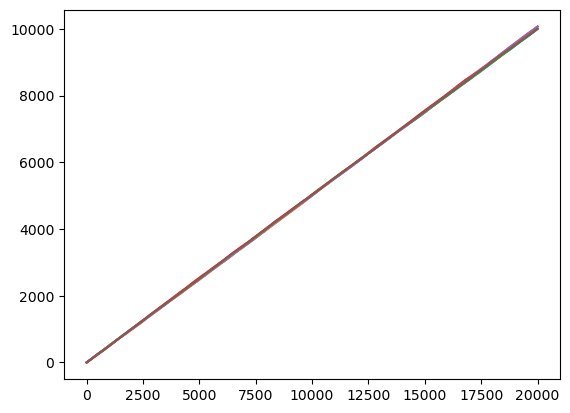

In [18]:
for alpha in ALPHAS:
    plt.plot(regret_result[alpha])

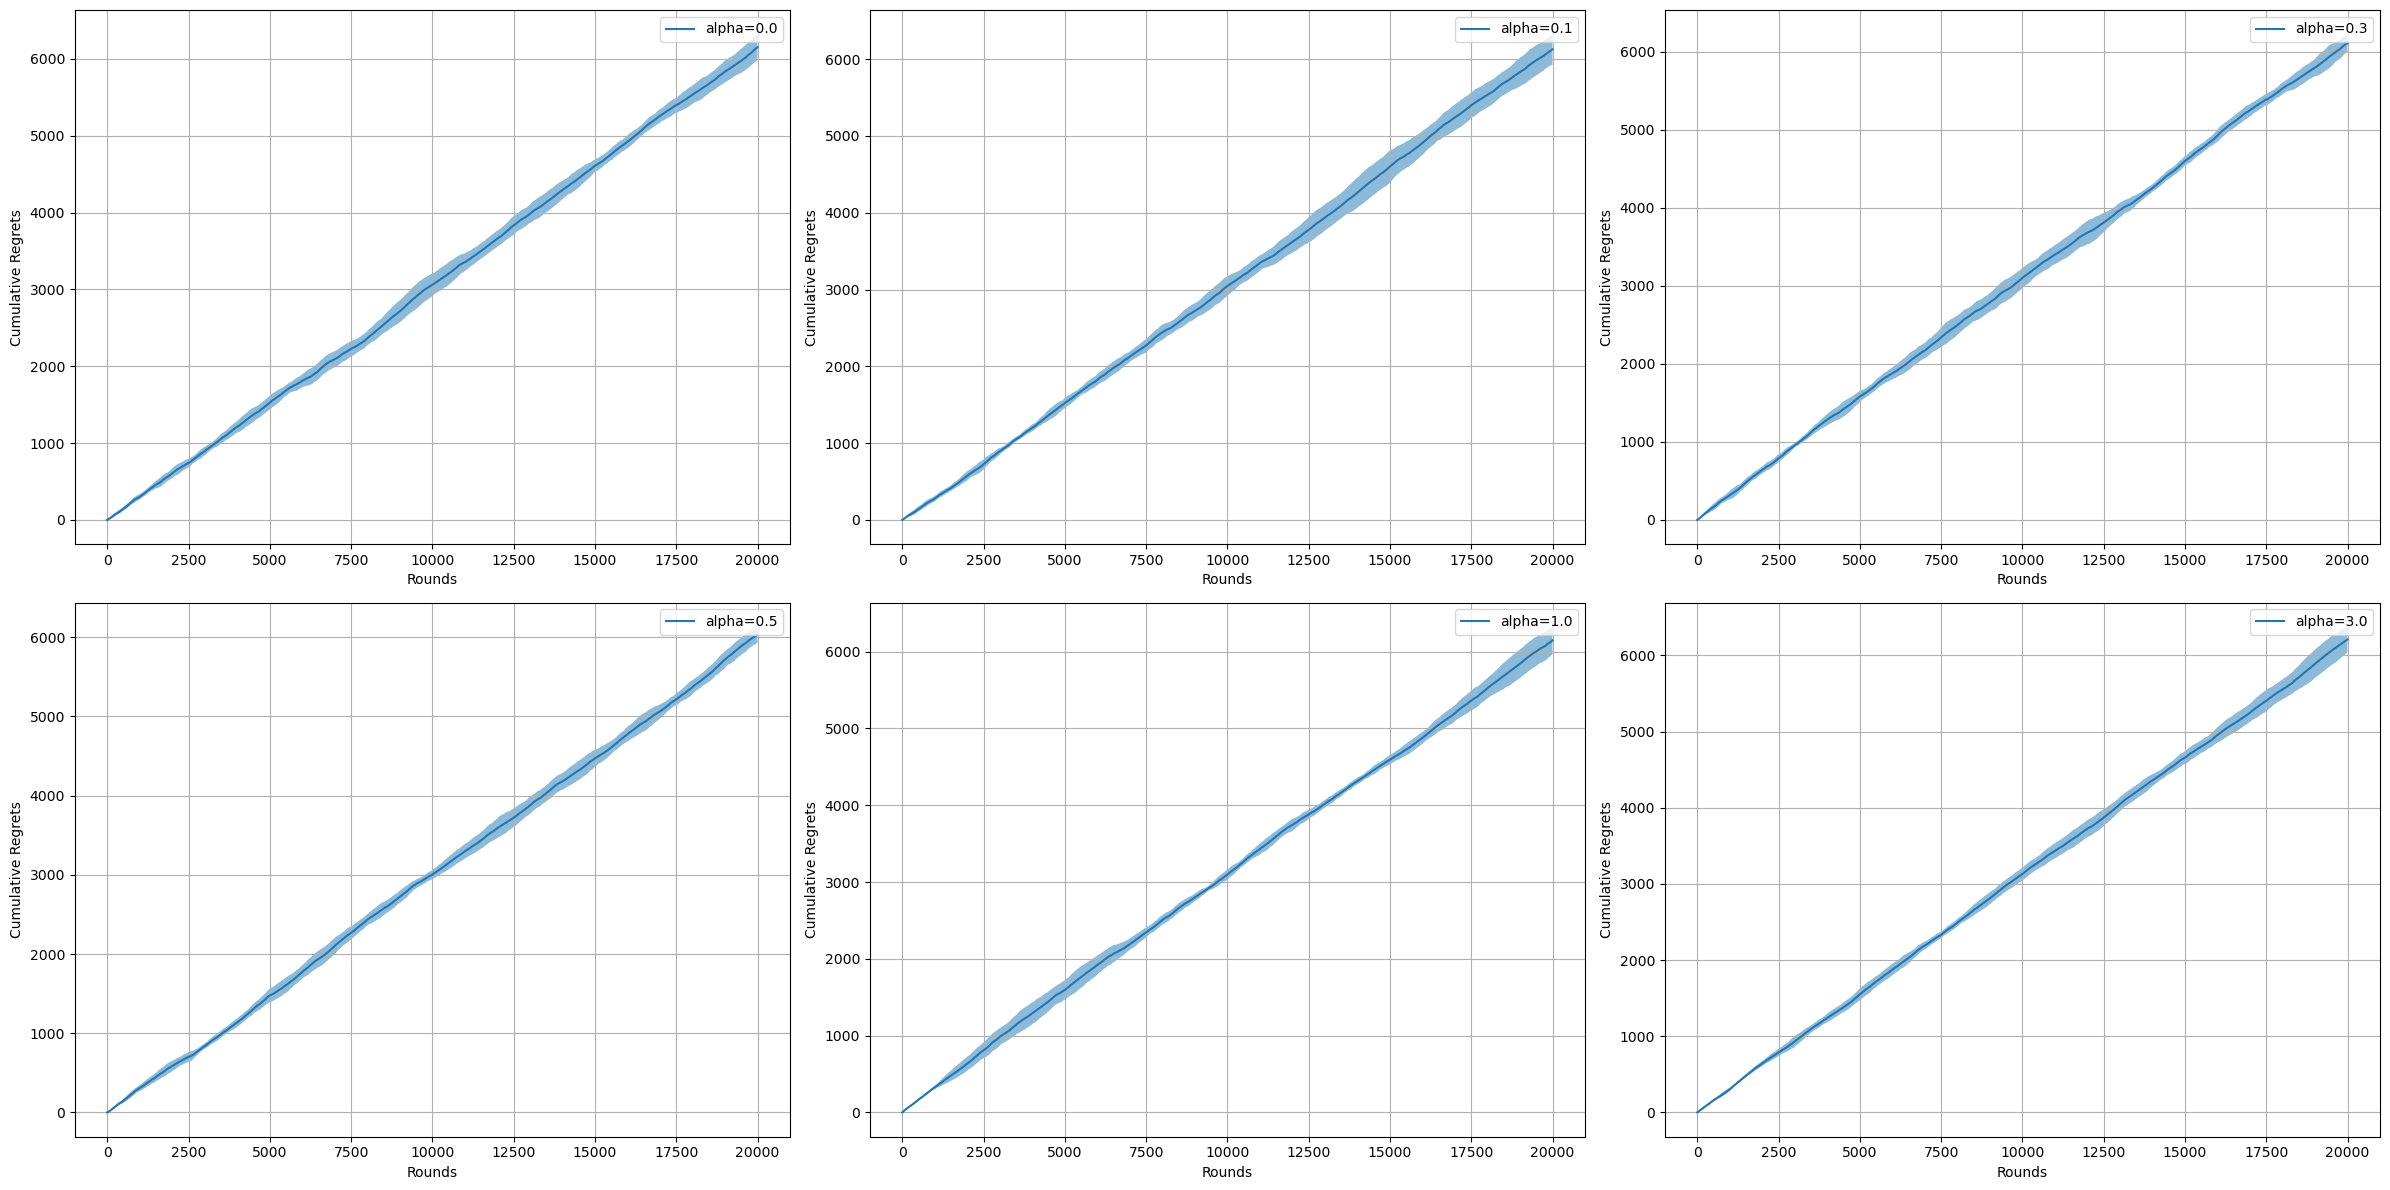

In [15]:
plt.figure(figsize=(24, 12))
for i, alpha in enumerate(result.keys()):
    mean = np.array(result[alpha]).mean(axis=0)
    std = np.array(result[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"23{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

## $Z\sim N(0, I_k)$

### Latent mapping $\sim$ Gaussian

#### $\sigma_\epsilon = 0.1$ (Low noise variance)

In [11]:
reward_noise = 0.1

In [12]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=True, map_dist="gaussian",
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=seed+trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6226.22it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6206.67it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6179.66it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6198.29it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6185.58it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6118.21it/s]


Trial 1
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6237.92it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6302.82it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6268.82it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6297.21it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6238.70it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6129.88it/s]


Trial 2
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6205.40it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6291.41it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6300.24it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6305.81it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6289.13it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6250.98it/s]


Trial 3
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6191.08it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6273.83it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6246.80it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6237.62it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6240.94it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6265.82it/s]


Trial 4
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6142.45it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6154.02it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6216.61it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6219.28it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6183.04it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6109.84it/s]


Trial 5
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6127.71it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6214.13it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6102.92it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6049.22it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6054.97it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6116.02it/s]


Trial 6
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6042.87it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6055.96it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6024.43it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6094.51it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6077.17it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6075.20it/s]


Trial 7
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6068.61it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6183.67it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6071.26it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6179.53it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6112.39it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6137.37it/s]


Trial 8
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6112.98it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6128.27it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6173.97it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6164.11it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6254.54it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6209.02it/s]


Trial 9
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:04<00:00, 4890.94it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6239.15it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6181.92it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6220.38it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6111.14it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6181.05it/s]


In [13]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([4.95398407e-01, 9.12807709e-01, 1.88745981e+00, ...,
       1.25737049e+03, 1.25737049e+03, 1.25737416e+03]), array([  0.95753352,   1.45657416,   1.76240632, ..., 928.13886066,
       928.13886066, 928.15348283]), array([1.31629000e-01, 6.79980640e-01, 1.67998064e+00, ...,
       1.51612839e+03, 1.51612839e+03, 1.51624736e+03]), array([2.45670349e-01, 3.03078274e-01, 4.69569463e-01, ...,
       1.33345640e+03, 1.33345640e+03, 1.33352167e+03]), array([2.81326918e-01, 4.70447586e-01, 7.32736916e-01, ...,
       9.11693136e+02, 9.11693136e+02, 9.11693136e+02]), array([4.04687054e-01, 1.40468705e+00, 1.86328254e+00, ...,
       9.40870529e+02, 9.40870529e+02, 9.41063383e+02]), array([4.54448305e-01, 6.24183205e-01, 1.31093337e+00, ...,
       1.11989552e+03, 1.11989552e+03, 1.12015381e+03]), array([7.24985758e-01, 1.38010544e+00, 1.88879746e+00, ...,
       1.61024366e+03, 1.61033940e+03, 1.61033940e+03]), array([1.48809352e-01, 3.98194229e-01, 1.

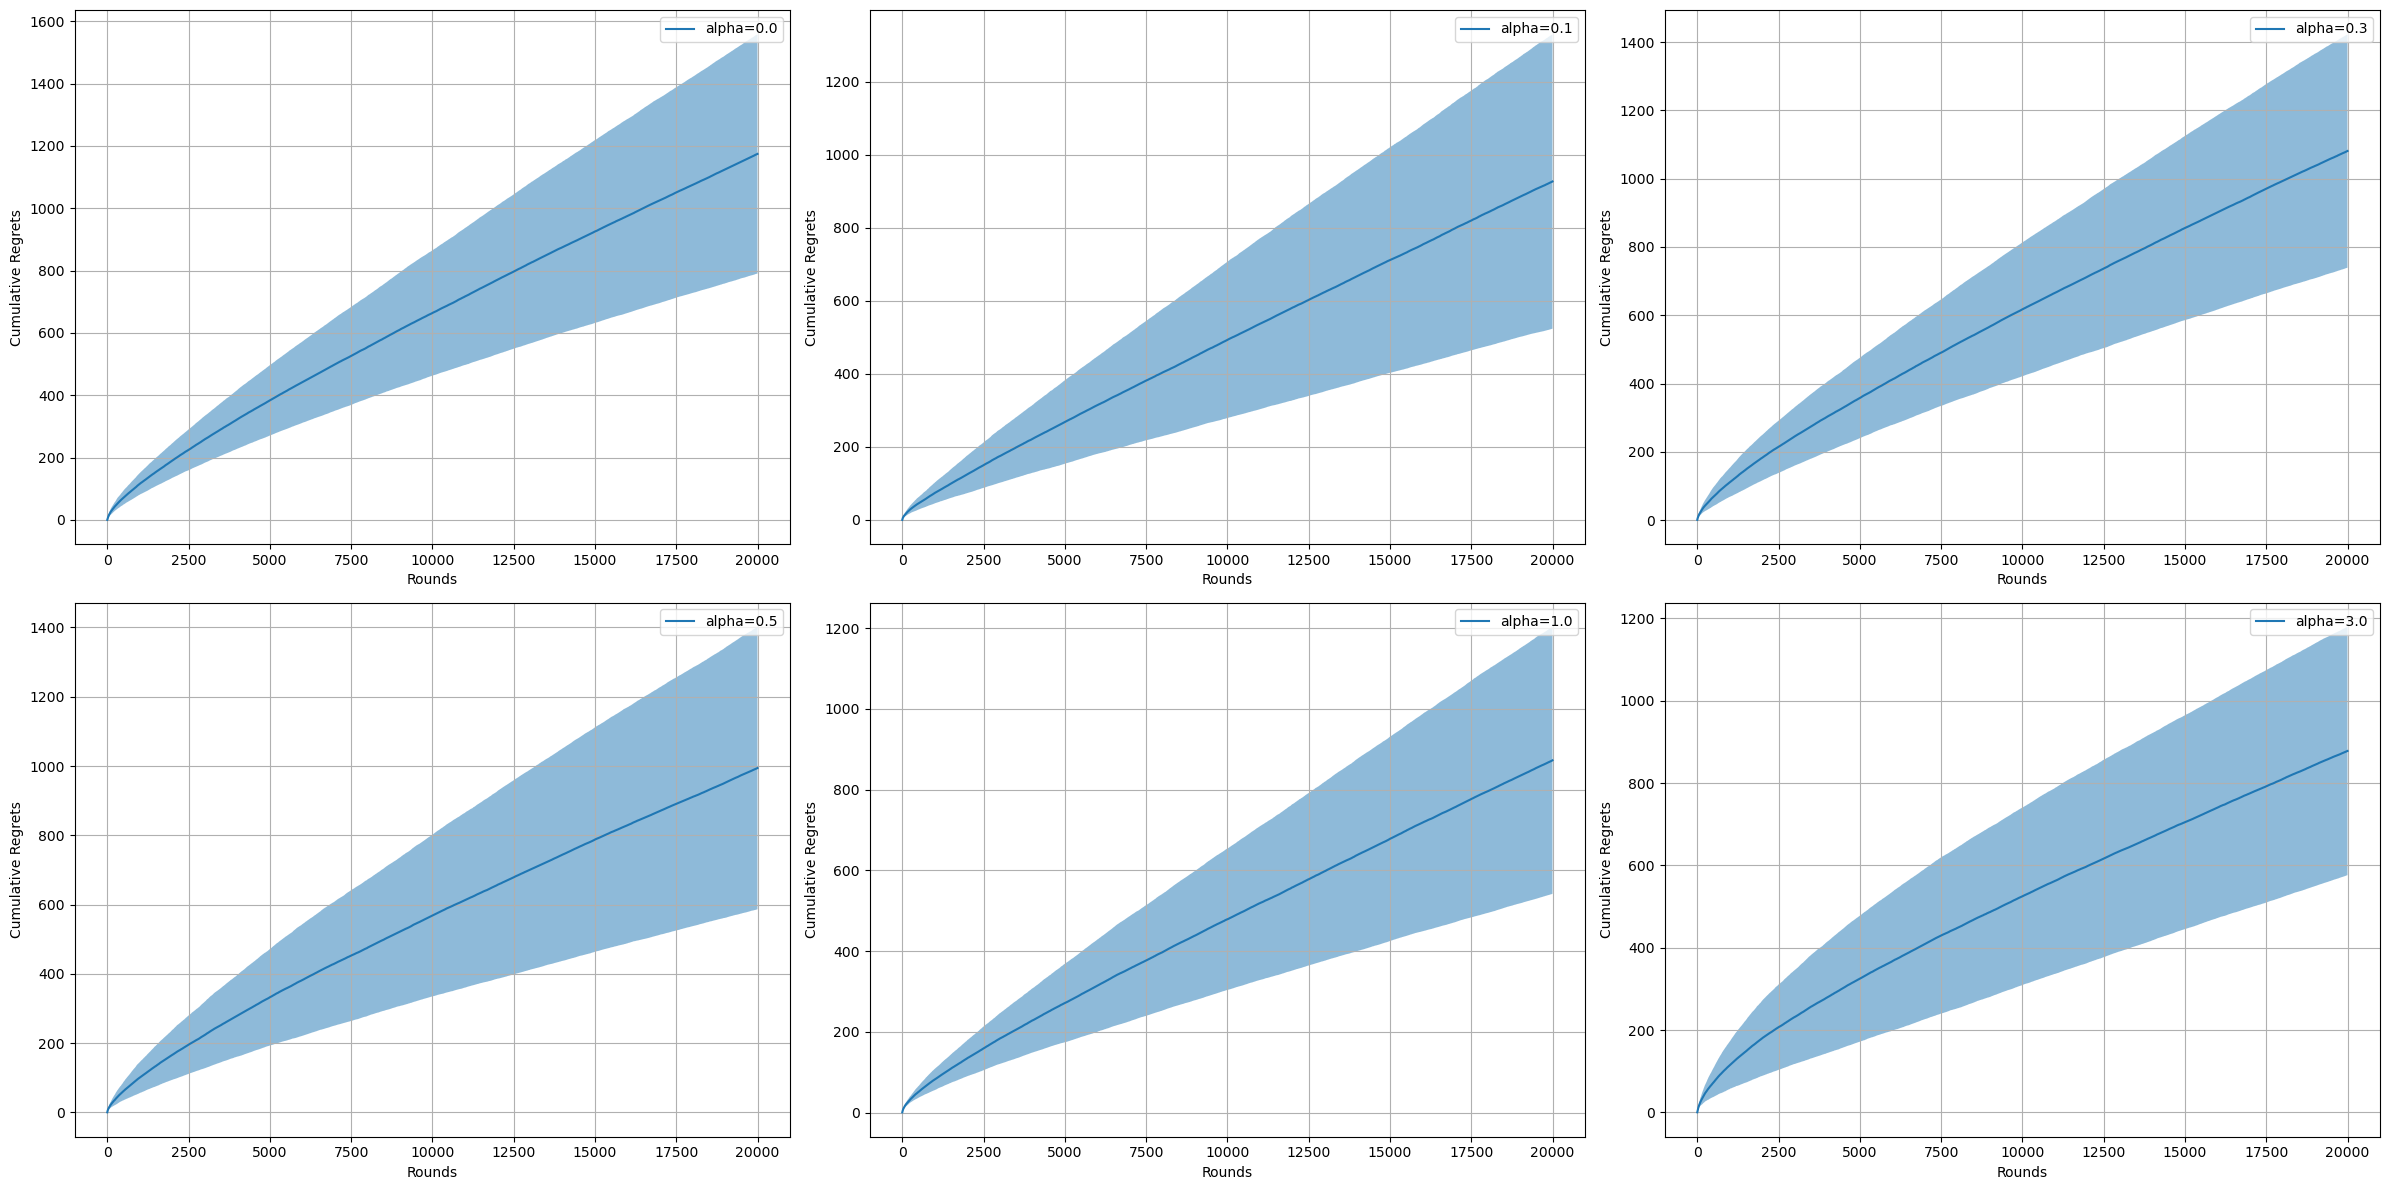

In [14]:
plt.figure(figsize=(24, 12))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"23{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

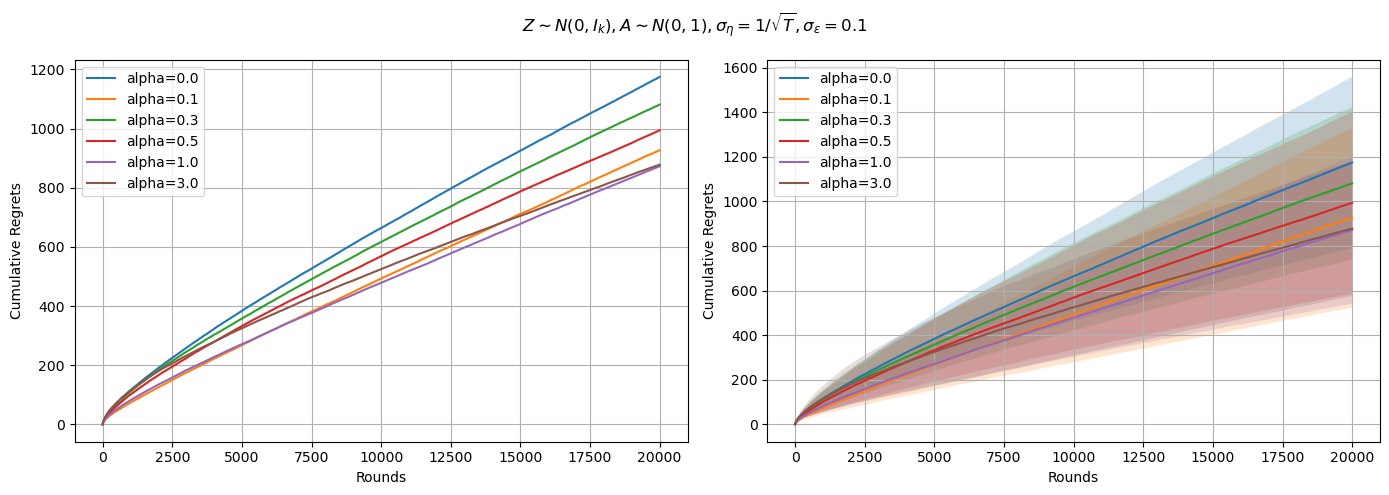

In [15]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.suptitle(f"$Z \sim N(0, I_k), A\sim N(0,1), \sigma_\eta=1/\sqrt{{T}}, \sigma_\epsilon={reward_noise}$")    
plt.tight_layout()
plt.show()

#### $\sigma_\epsilon = 0.5$ (High noise variance)

In [16]:
reward_noise = 0.5

In [17]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=True, map_dist="gaussian",
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=seed+trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6210.10it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6321.05it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6328.11it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6277.33it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6292.27it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6211.62it/s]


Trial 1
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6239.68it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6301.36it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6258.38it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6143.30it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6223.23it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6288.43it/s]


Trial 2
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6144.13it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6129.01it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6056.62it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6331.58it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6299.46it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6263.06it/s]


Trial 3
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6247.03it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6286.17it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6120.28it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6097.02it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6183.55it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6030.52it/s]


Trial 4
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6171.00it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6169.79it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6195.37it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6091.85it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6079.53it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6038.17it/s]


Trial 5
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6111.07it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6042.29it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6191.99it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6149.36it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6229.03it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6068.90it/s]


Trial 6
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6168.20it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6205.38it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6335.07it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6171.29it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6202.73it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6375.17it/s]


Trial 7
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6097.43it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6222.53it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6262.22it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6288.44it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6298.50it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6174.44it/s]


Trial 8
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6226.71it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6265.96it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6241.77it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6303.53it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6217.57it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6250.70it/s]


Trial 9
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6113.60it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6312.63it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6211.22it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6172.85it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6317.17it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6302.85it/s]


In [18]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([4.95398407e-01, 9.12807709e-01, 1.88745981e+00, ...,
       3.17714263e+03, 3.17714263e+03, 3.17714263e+03]), array([9.57533525e-01, 1.45657416e+00, 1.76240632e+00, ...,
       3.37458594e+03, 3.37458594e+03, 3.37496851e+03]), array([1.31629000e-01, 6.79980640e-01, 1.67998064e+00, ...,
       3.55708533e+03, 3.55723856e+03, 3.55737255e+03]), array([2.45670349e-01, 3.03078274e-01, 4.69569463e-01, ...,
       2.63004779e+03, 2.63004779e+03, 2.63011306e+03]), array([2.81326918e-01, 4.70447586e-01, 7.32736916e-01, ...,
       2.15085839e+03, 2.15090364e+03, 2.15092875e+03]), array([4.04687054e-01, 1.40468705e+00, 2.40468705e+00, ...,
       4.70768732e+03, 4.70768732e+03, 4.70810708e+03]), array([4.54448305e-01, 6.24183205e-01, 1.31093337e+00, ...,
       2.43045259e+03, 2.43080550e+03, 2.43106378e+03]), array([7.24985758e-01, 1.38010544e+00, 1.88879746e+00, ...,
       4.54264230e+03, 4.54273089e+03, 4.54277065e+03]), array([1.48809352e-01, 3.9819

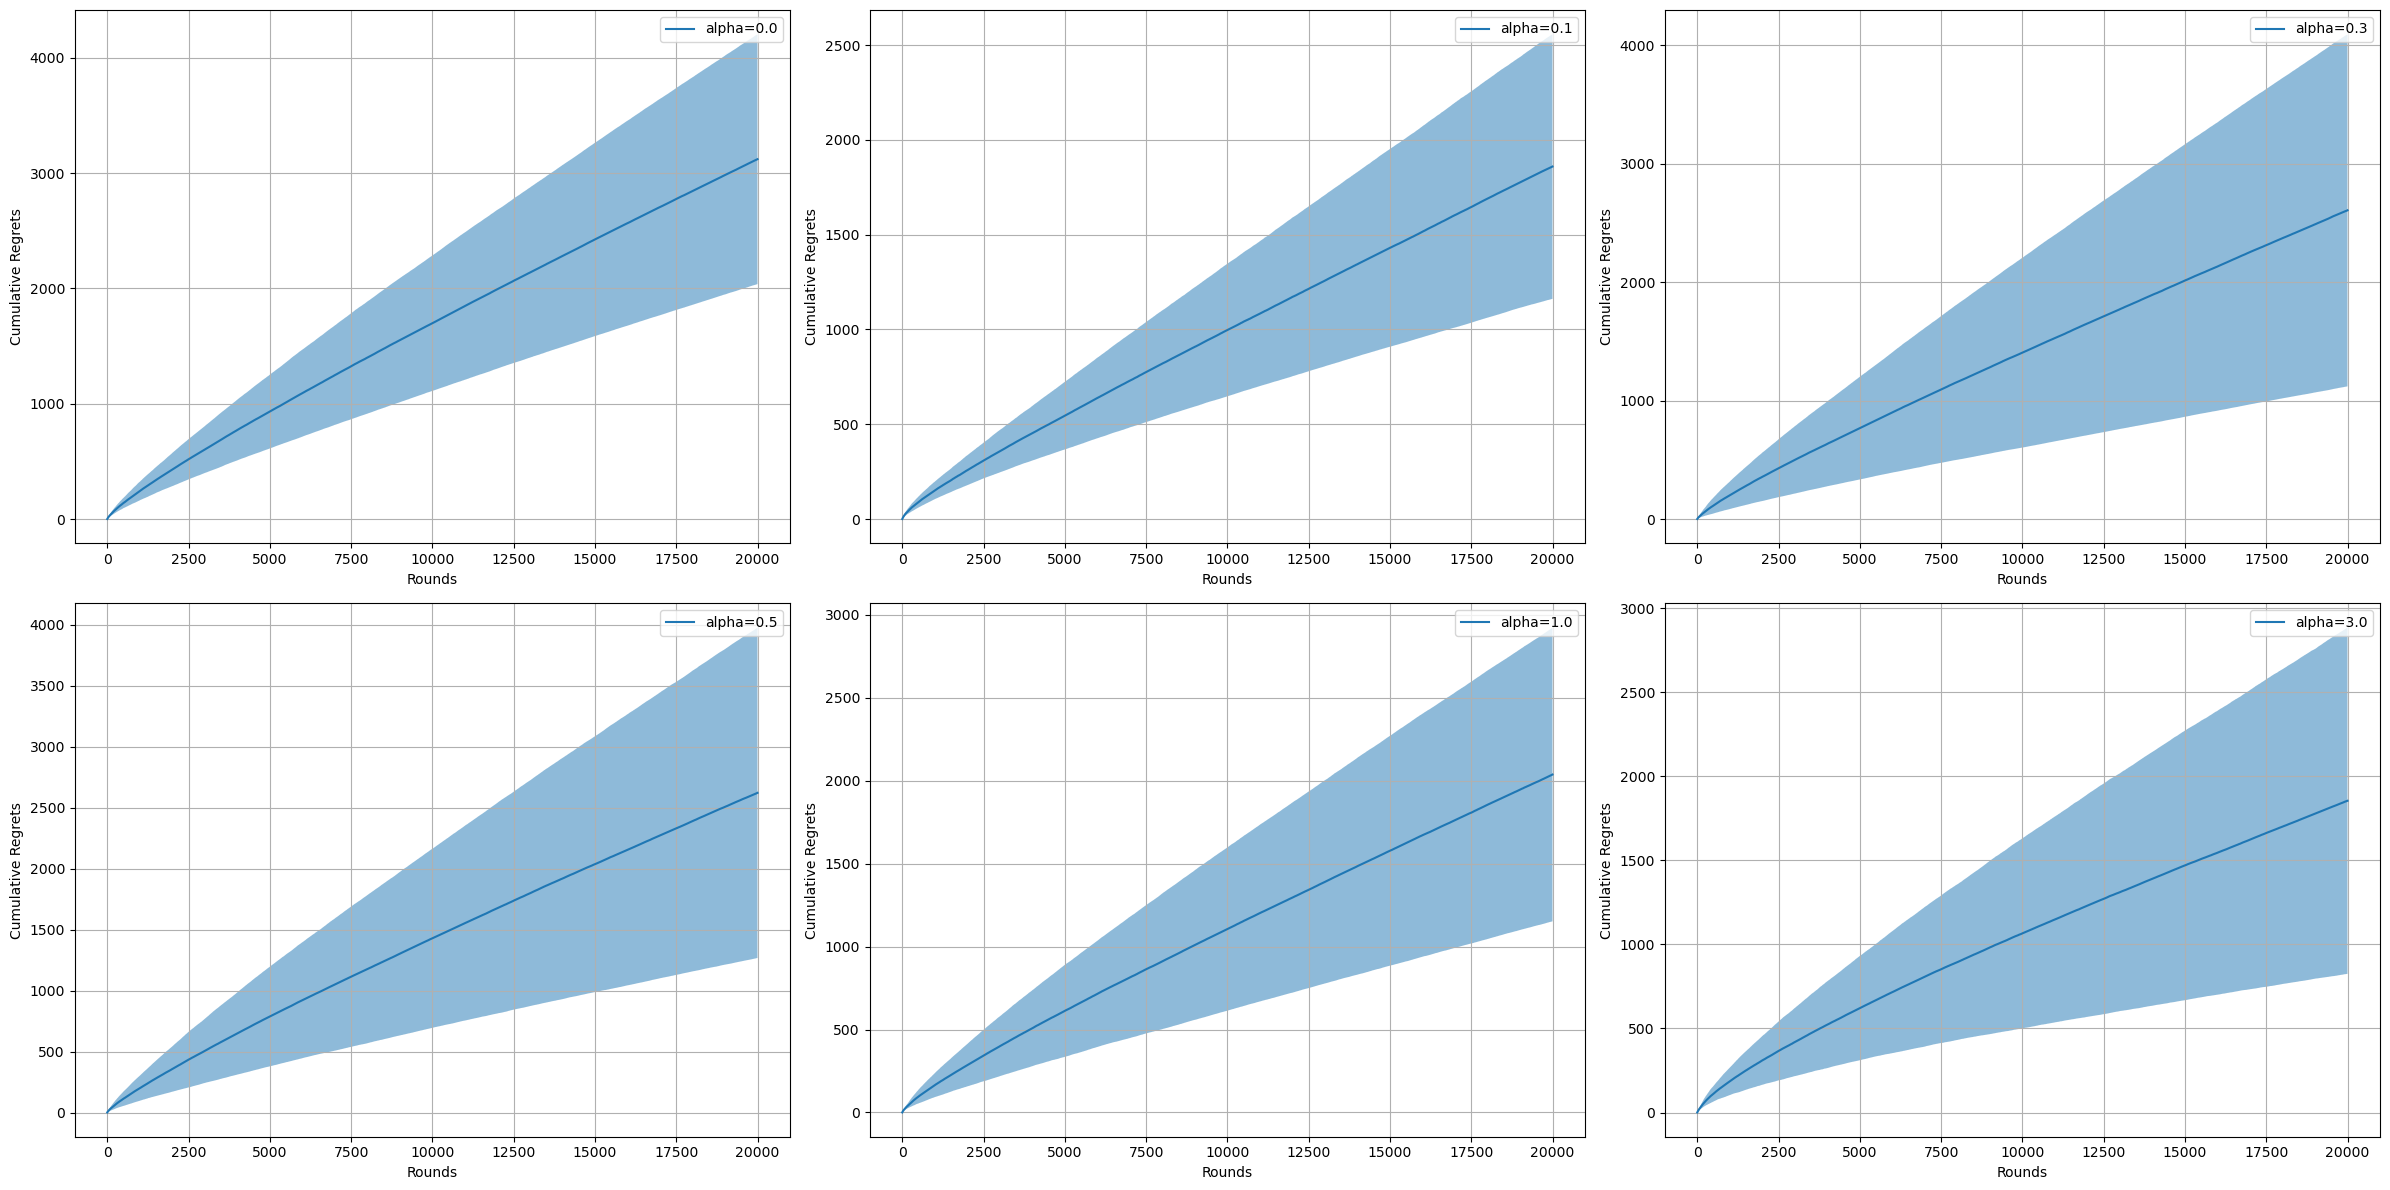

In [19]:
plt.figure(figsize=(24, 12))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"23{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

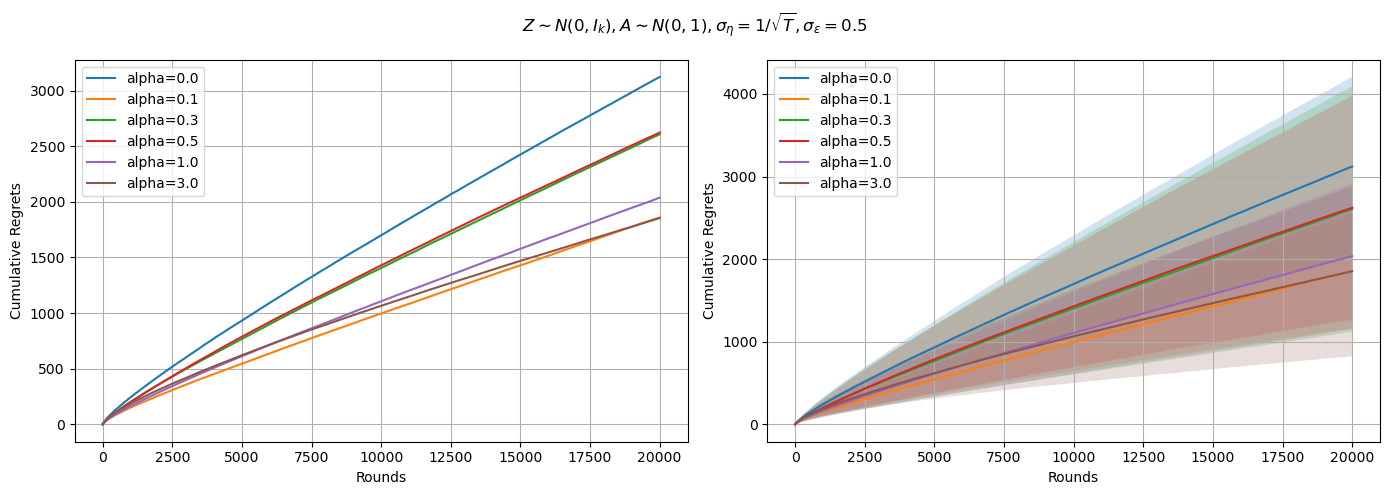

In [20]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.suptitle(f"$Z \sim N(0, I_k), A\sim N(0,1), \sigma_\eta=1/\sqrt{{T}}, \sigma_\epsilon={reward_noise}$")
plt.tight_layout()
plt.show()

### Latent mapping $\sim$ Uniform

#### $\sigma_\epsilon = 0.1$ (Low noise variance)

In [21]:
reward_noise = 0.1

In [22]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=True, map_dist="uniform",
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=seed+trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6160.21it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6303.94it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6332.26it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6282.75it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6257.80it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6253.95it/s]


Trial 1
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6229.33it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6267.00it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6314.45it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6238.25it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6269.60it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6227.49it/s]


Trial 2
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6195.62it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6257.35it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6248.57it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6174.46it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6158.52it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6168.35it/s]


Trial 3
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6209.21it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6282.86it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6195.06it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6219.84it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6248.45it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6260.43it/s]


Trial 4
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6144.26it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6210.17it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6263.81it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6247.20it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6293.00it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6250.66it/s]


Trial 5
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6199.63it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6280.27it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6301.63it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6278.04it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6326.99it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6273.02it/s]


Trial 6
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6117.17it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6288.37it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6180.46it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6320.80it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6297.89it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6295.22it/s]


Trial 7
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6226.07it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6299.24it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6297.73it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6266.81it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6219.02it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6263.07it/s]


Trial 8
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6207.44it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6257.56it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6191.80it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6181.74it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6108.89it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6059.55it/s]


Trial 9
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6120.72it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6164.23it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6216.47it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6194.59it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6187.14it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6145.79it/s]


In [23]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([  0.77771369,   1.77771369,   2.77771369, ..., 596.16565423,
       596.16565423, 596.28310241]), array([9.72259066e-02, 6.80427165e-01, 9.89981229e-01, ...,
       5.59364115e+02, 5.59484451e+02, 5.59487545e+02]), array([  0.76594061,   1.190802  ,   1.4423084 , ..., 428.96589909,
       428.96589909, 428.96589909]), array([  0.87507791,   1.82759719,   2.72345949, ..., 626.74655309,
       626.74655309, 626.74655309]), array([  0.6091851 ,   1.33859198,   2.11181514, ..., 554.24341984,
       554.24341984, 554.24354696]), array([1.00000000e+00, 2.00000000e+00, 2.82979057e+00, ...,
       1.12504127e+03, 1.12512393e+03, 1.12520922e+03]), array([  1.        ,   1.85241859,   2.85241859, ..., 785.41253152,
       785.41253152, 785.41253152]), array([  0.89936936,   1.6969973 ,   2.31198156, ..., 578.87319538,
       578.87319538, 579.06389176]), array([  0.56099812,   0.56099812,   0.78057454, ..., 279.42603446,
       279.42603446, 279.46577132

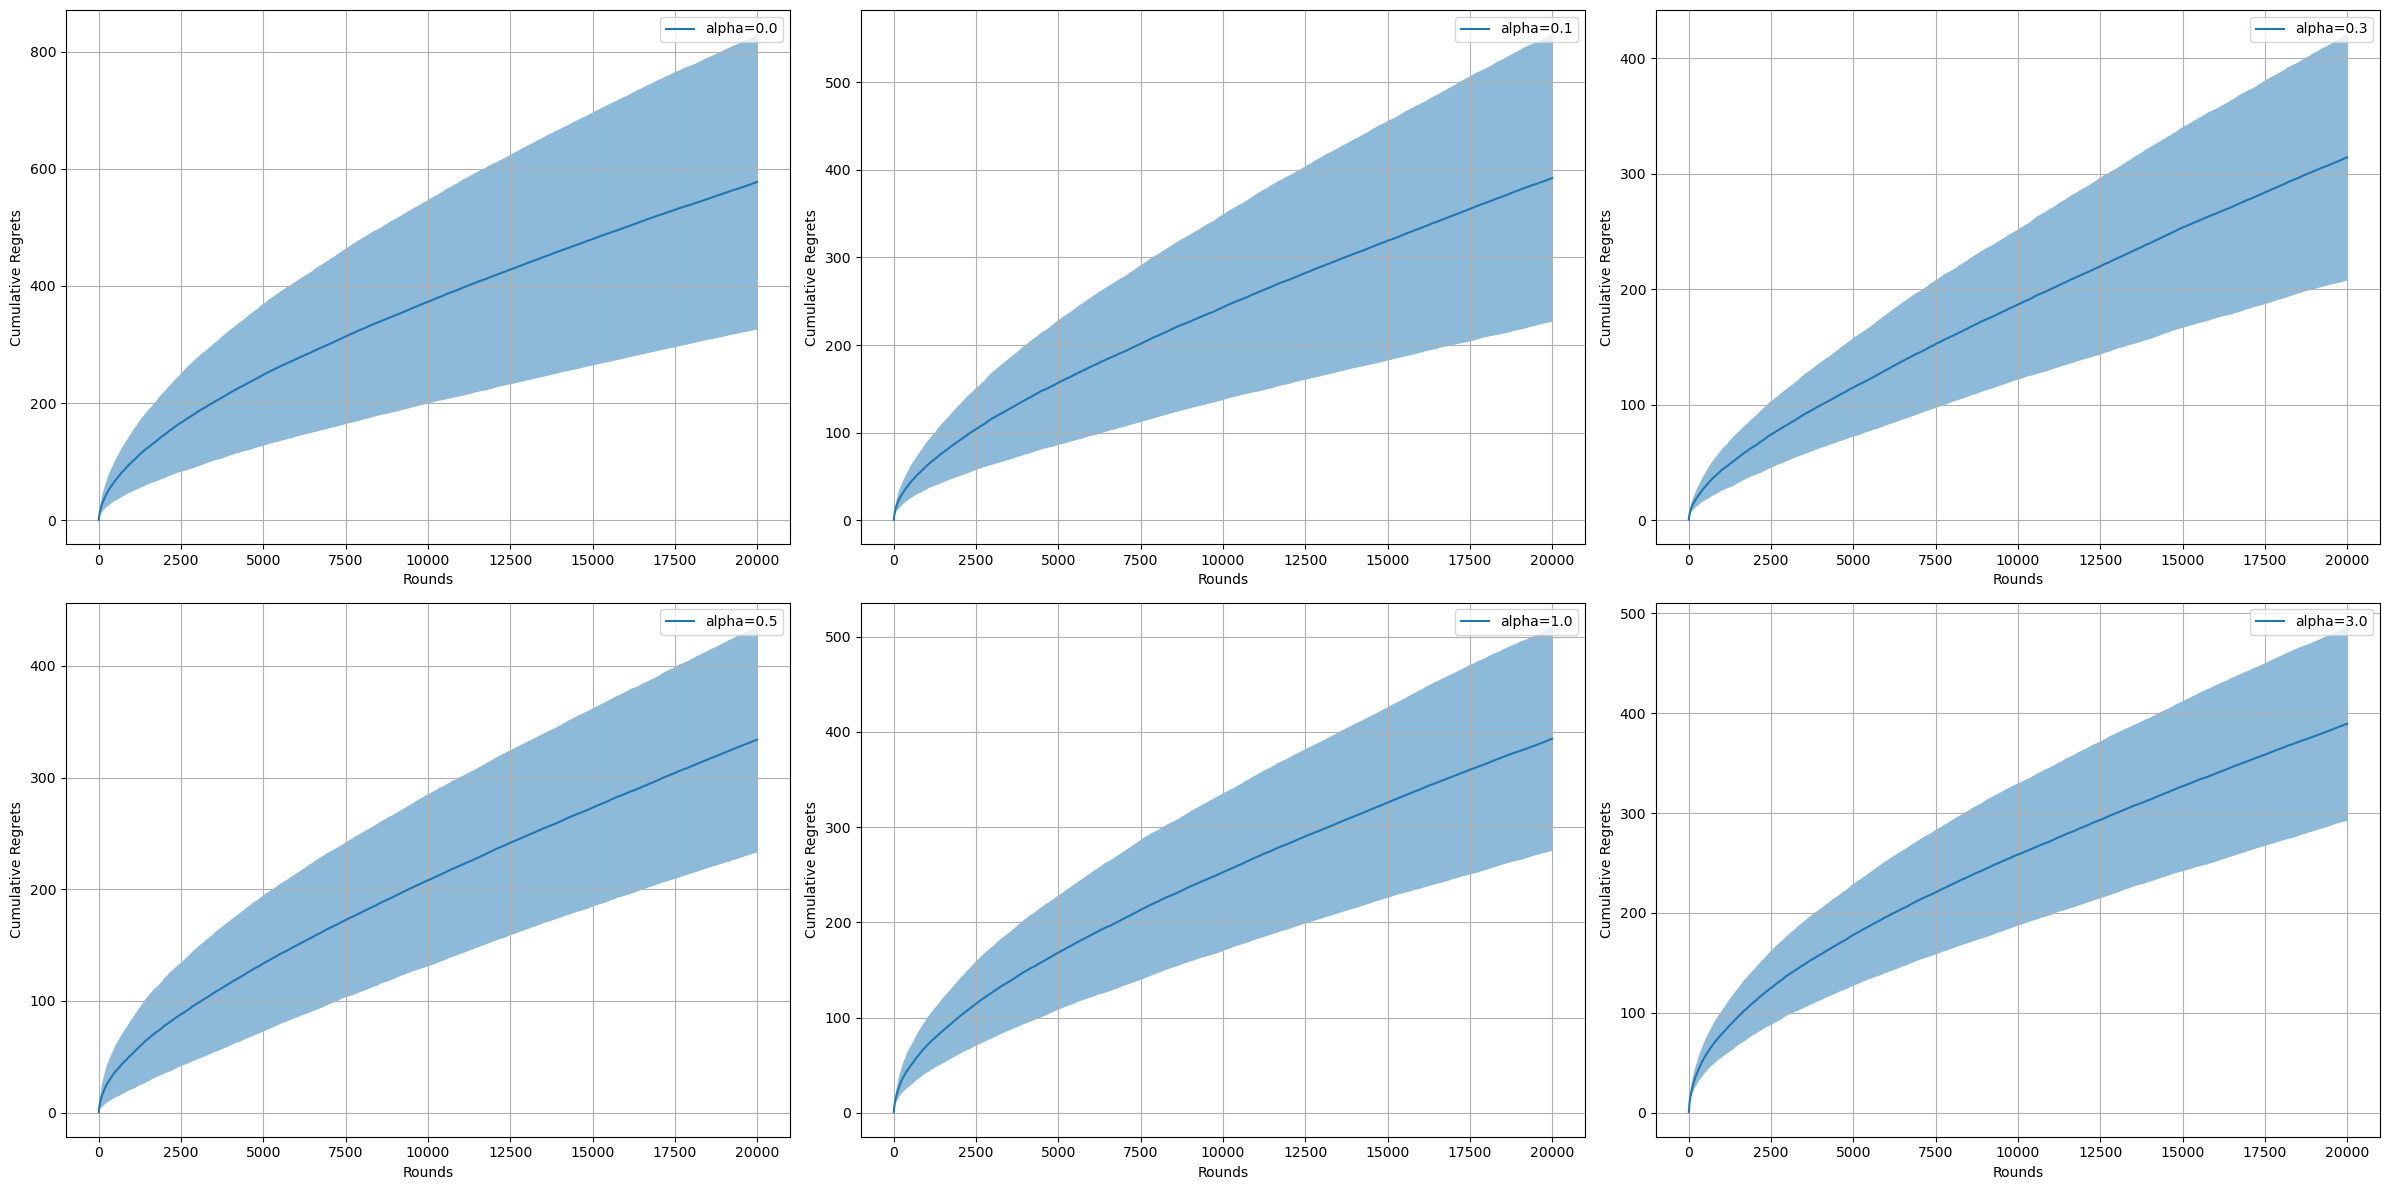

In [24]:
plt.figure(figsize=(24, 12))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"23{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

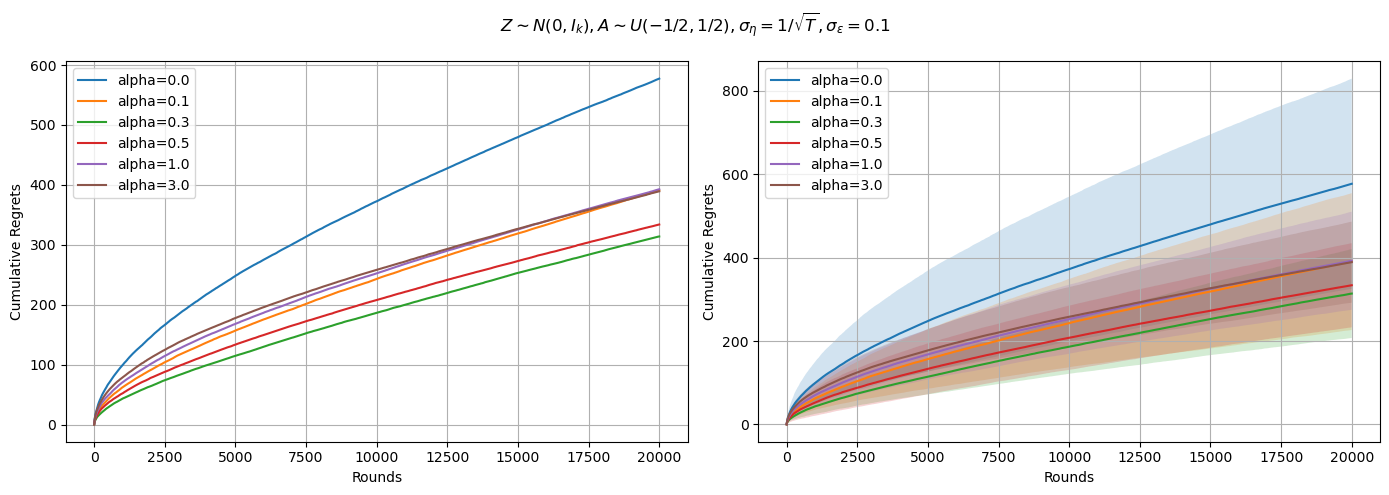

In [25]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.suptitle(f"$Z \sim N(0, I_k), A\sim U(-1/2, 1/2), \sigma_\eta=1/\sqrt{{T}}, \sigma_\epsilon={reward_noise}$")
plt.tight_layout()
plt.show()

#### $\sigma_\epsilon = 0.5$ (High noise variance)

In [26]:
reward_noise = 0.5

In [27]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=True, map_dist="uniform",
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=seed+trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6175.00it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6259.00it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6038.85it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6088.93it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6151.00it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6293.10it/s]


Trial 1
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6249.49it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6192.72it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6160.91it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6289.21it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6032.47it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6165.13it/s]


Trial 2
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5949.60it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6121.16it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6126.03it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6201.79it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6212.09it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6145.65it/s]


Trial 3
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6133.40it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6019.47it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6124.32it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6119.17it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6176.74it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6273.91it/s]


Trial 4
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6008.76it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6286.19it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6047.25it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6126.00it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6239.17it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6235.97it/s]


Trial 5
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6097.67it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6188.66it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6201.21it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6222.15it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6189.00it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6199.12it/s]


Trial 6
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6020.82it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6077.87it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6204.34it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6028.20it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6098.18it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6077.93it/s]


Trial 7
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5996.18it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6181.94it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 5980.87it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6044.64it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6154.19it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6089.44it/s]


Trial 8
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5926.96it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6179.10it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6073.38it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6032.45it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6002.86it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6004.74it/s]


Trial 9
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6065.19it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6214.65it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6026.08it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6152.53it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6200.15it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5998.23it/s]


In [28]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([7.77713686e-01, 1.77771369e+00, 2.77771369e+00, ...,
       2.60010433e+03, 2.60010433e+03, 2.60040382e+03]), array([9.72259066e-02, 6.80427165e-01, 9.89981229e-01, ...,
       1.63464696e+03, 1.63476729e+03, 1.63477039e+03]), array([7.65940605e-01, 1.19080200e+00, 1.44230840e+00, ...,
       1.61381941e+03, 1.61381941e+03, 1.61404708e+03]), array([8.75077915e-01, 1.82759719e+00, 2.72345949e+00, ...,
       3.27851203e+03, 3.27864417e+03, 3.27864417e+03]), array([6.09185103e-01, 1.33859198e+00, 2.11181514e+00, ...,
       2.20425435e+03, 2.20425435e+03, 2.20425447e+03]), array([1.00000000e+00, 2.00000000e+00, 2.82979057e+00, ...,
       5.46682099e+03, 5.46729889e+03, 5.46729889e+03]), array([1.00000000e+00, 1.85241859e+00, 2.85241859e+00, ...,
       2.80132575e+03, 2.80148292e+03, 2.80148292e+03]), array([8.99369359e-01, 1.69699730e+00, 2.31198156e+00, ...,
       3.09481851e+03, 3.09481851e+03, 3.09506855e+03]), array([5.60998125e-01, 5.6099

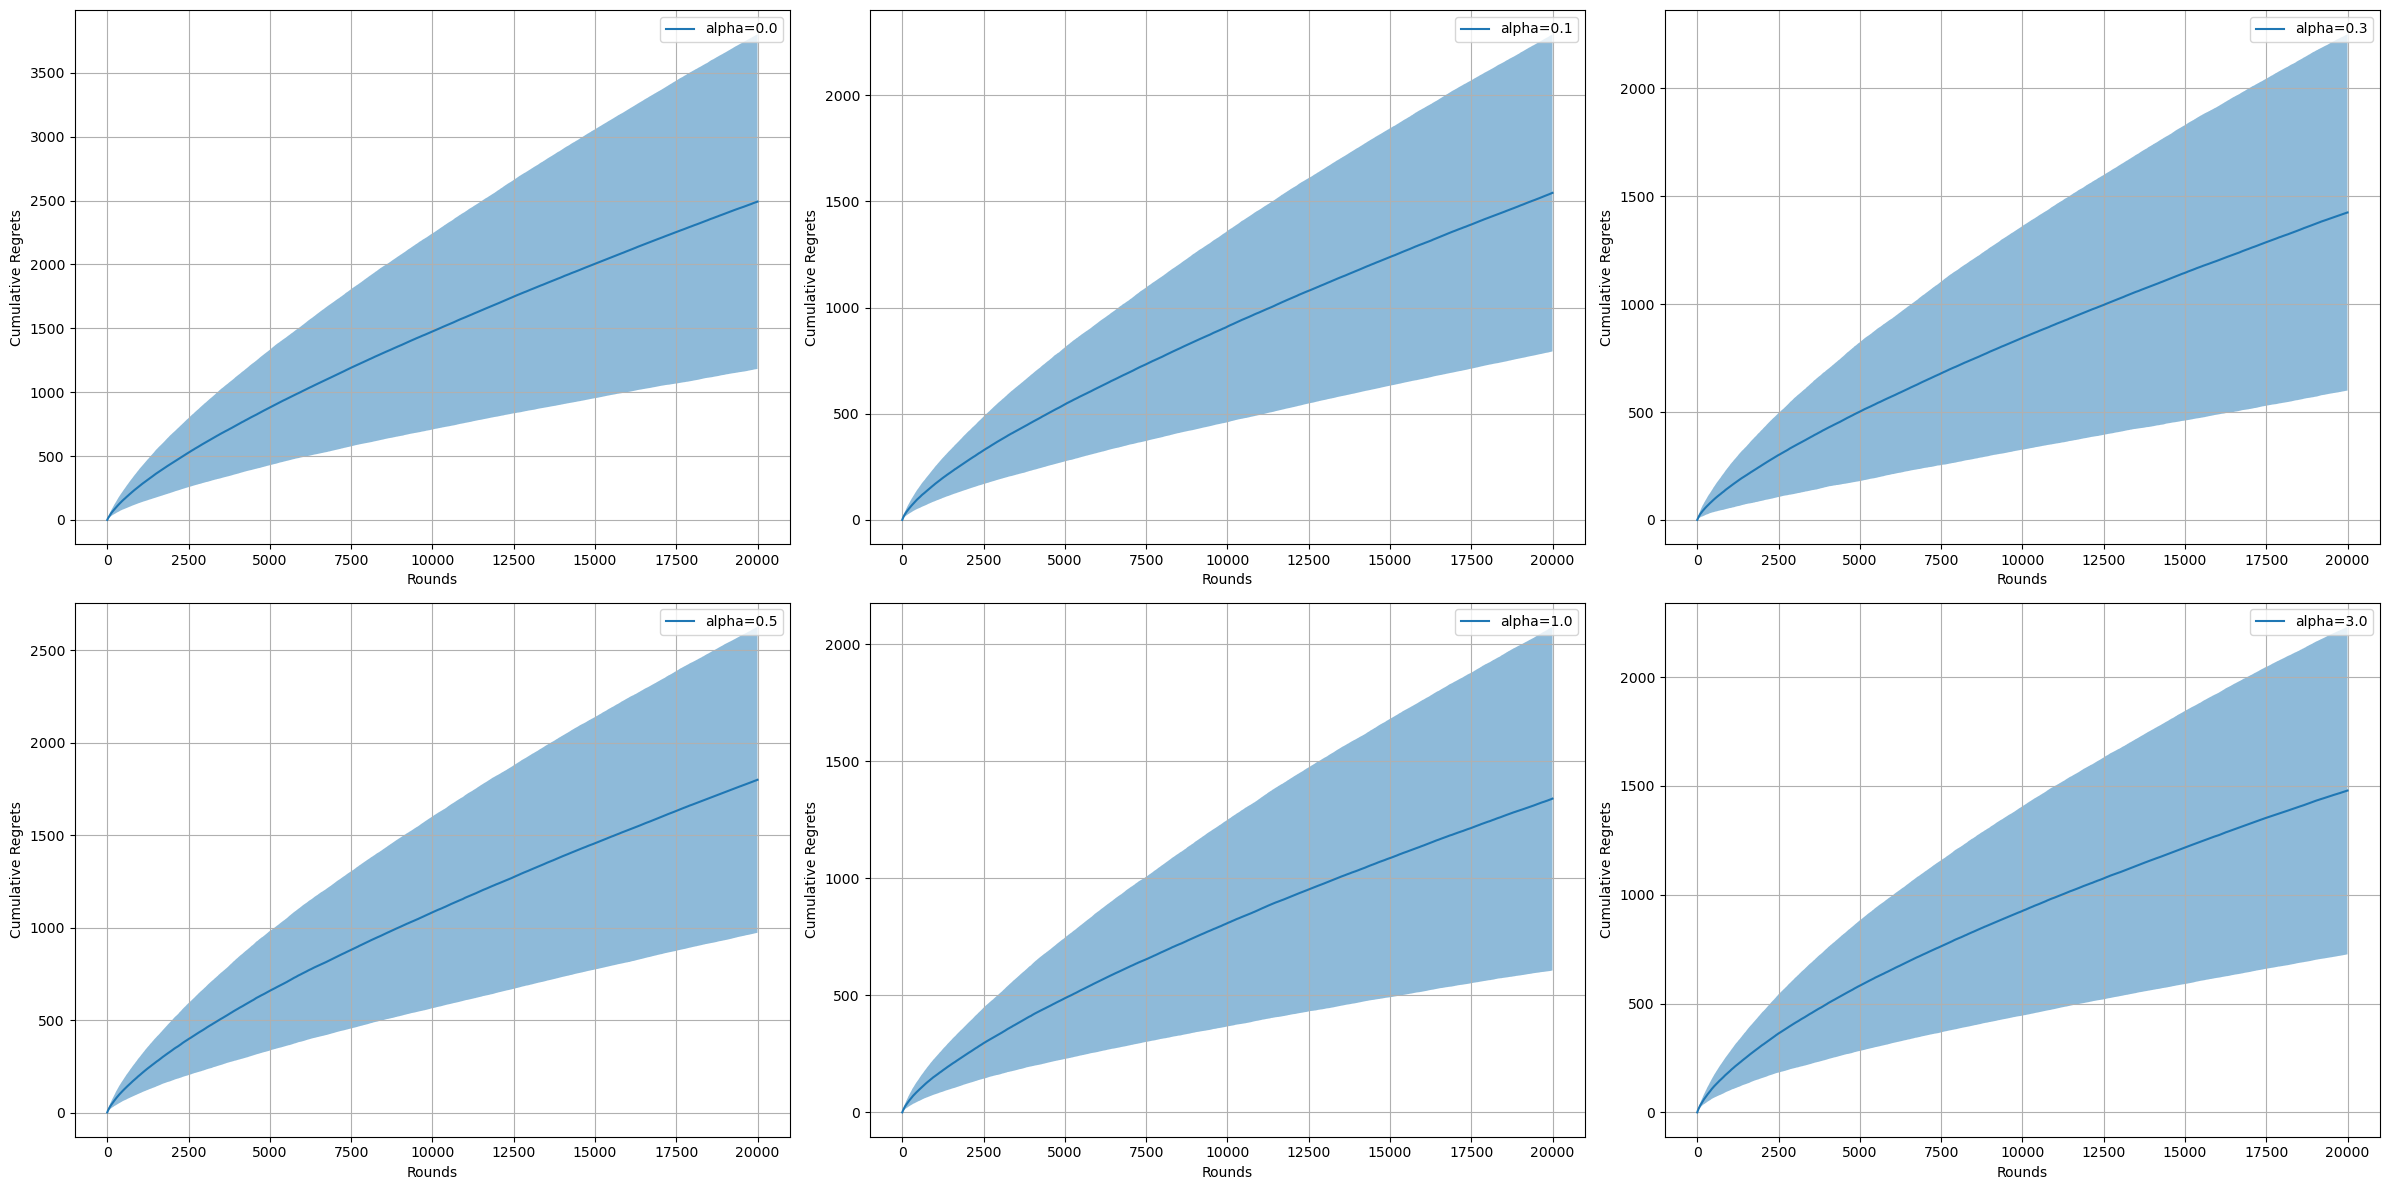

In [29]:
plt.figure(figsize=(24, 12))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"23{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

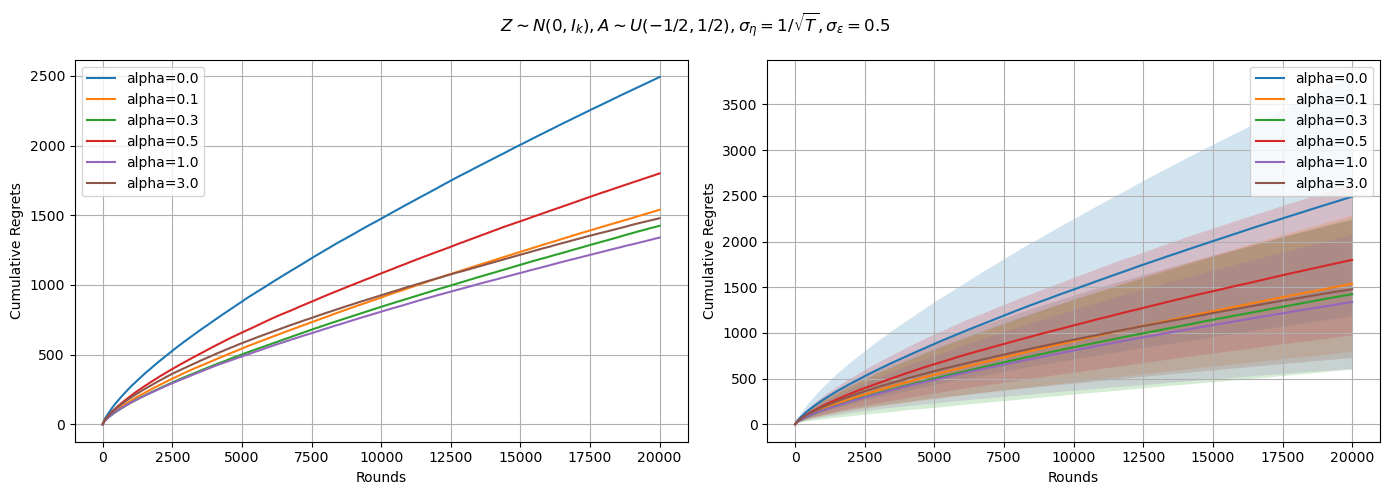

In [30]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.suptitle(f"$Z \sim N(0, I_k), A\sim U(-1/2, 1/2), \sigma_\eta=1/\sqrt{{T}}, \sigma_\epsilon={reward_noise}$")
plt.tight_layout()
plt.show()

## $Z\sim N(0, \Sigma_k)$

### Latent mapping $\sim$ Gaussian

#### $\sigma_\epsilon = 0.1$ (Low noise variance)

In [31]:
reward_noise = 0.1

In [32]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=False, map_dist="gaussian",
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=seed+trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6126.13it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6172.76it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6131.26it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6160.25it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6122.22it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6126.30it/s]


Trial 1
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6136.47it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6268.38it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6162.13it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6220.91it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6153.91it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6231.92it/s]


Trial 2
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6222.90it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6234.06it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6153.55it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6140.40it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6066.76it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6098.75it/s]


Trial 3
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6215.64it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6184.17it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6231.88it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6142.28it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6192.10it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6240.23it/s]


Trial 4
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6130.63it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6084.84it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6176.40it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6252.32it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6193.43it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6152.31it/s]


Trial 5
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6174.31it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6298.88it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6279.03it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6270.22it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6228.19it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6146.38it/s]


Trial 6
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6196.02it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6257.74it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6190.12it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6170.22it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6166.27it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6265.84it/s]


Trial 7
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6219.31it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6328.66it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6266.48it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6295.48it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6221.46it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6236.48it/s]


Trial 8
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6050.55it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6251.63it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6275.28it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6304.02it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6102.74it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6276.76it/s]


Trial 9
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6232.73it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6326.96it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6301.67it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6225.99it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6236.51it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6273.38it/s]


In [33]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([6.63941509e-01, 1.44499706e+00, 2.29949914e+00, ...,
       1.17902579e+03, 1.17930943e+03, 1.17930943e+03]), array([2.96142113e-01, 4.71232700e-01, 5.80340200e-01, ...,
       1.52975016e+03, 1.52975016e+03, 1.52977260e+03]), array([  0.        ,   0.        ,   0.        , ..., 625.76802039,
       625.76802039, 625.76802039]), array([1.00000000e+00, 1.87695233e+00, 2.66279034e+00, ...,
       2.49260154e+03, 2.49267709e+03, 2.49275651e+03]), array([3.73292176e-02, 4.67887315e-01, 9.71597994e-01, ...,
       7.84002251e+02, 7.84046692e+02, 7.84046692e+02]), array([1.02164287e-02, 2.33949811e-01, 5.16286714e-01, ...,
       7.28084088e+02, 7.28084088e+02, 7.28084088e+02]), array([8.92103001e-01, 1.89210300e+00, 2.89210300e+00, ...,
       1.36937849e+03, 1.36937849e+03, 1.36939487e+03]), array([  0.99034542,   1.95864234,   2.9261219 , ..., 927.48236405,
       927.48236405, 927.53273308]), array([3.61803204e-02, 2.45528515e-01, 3.19820164e-01

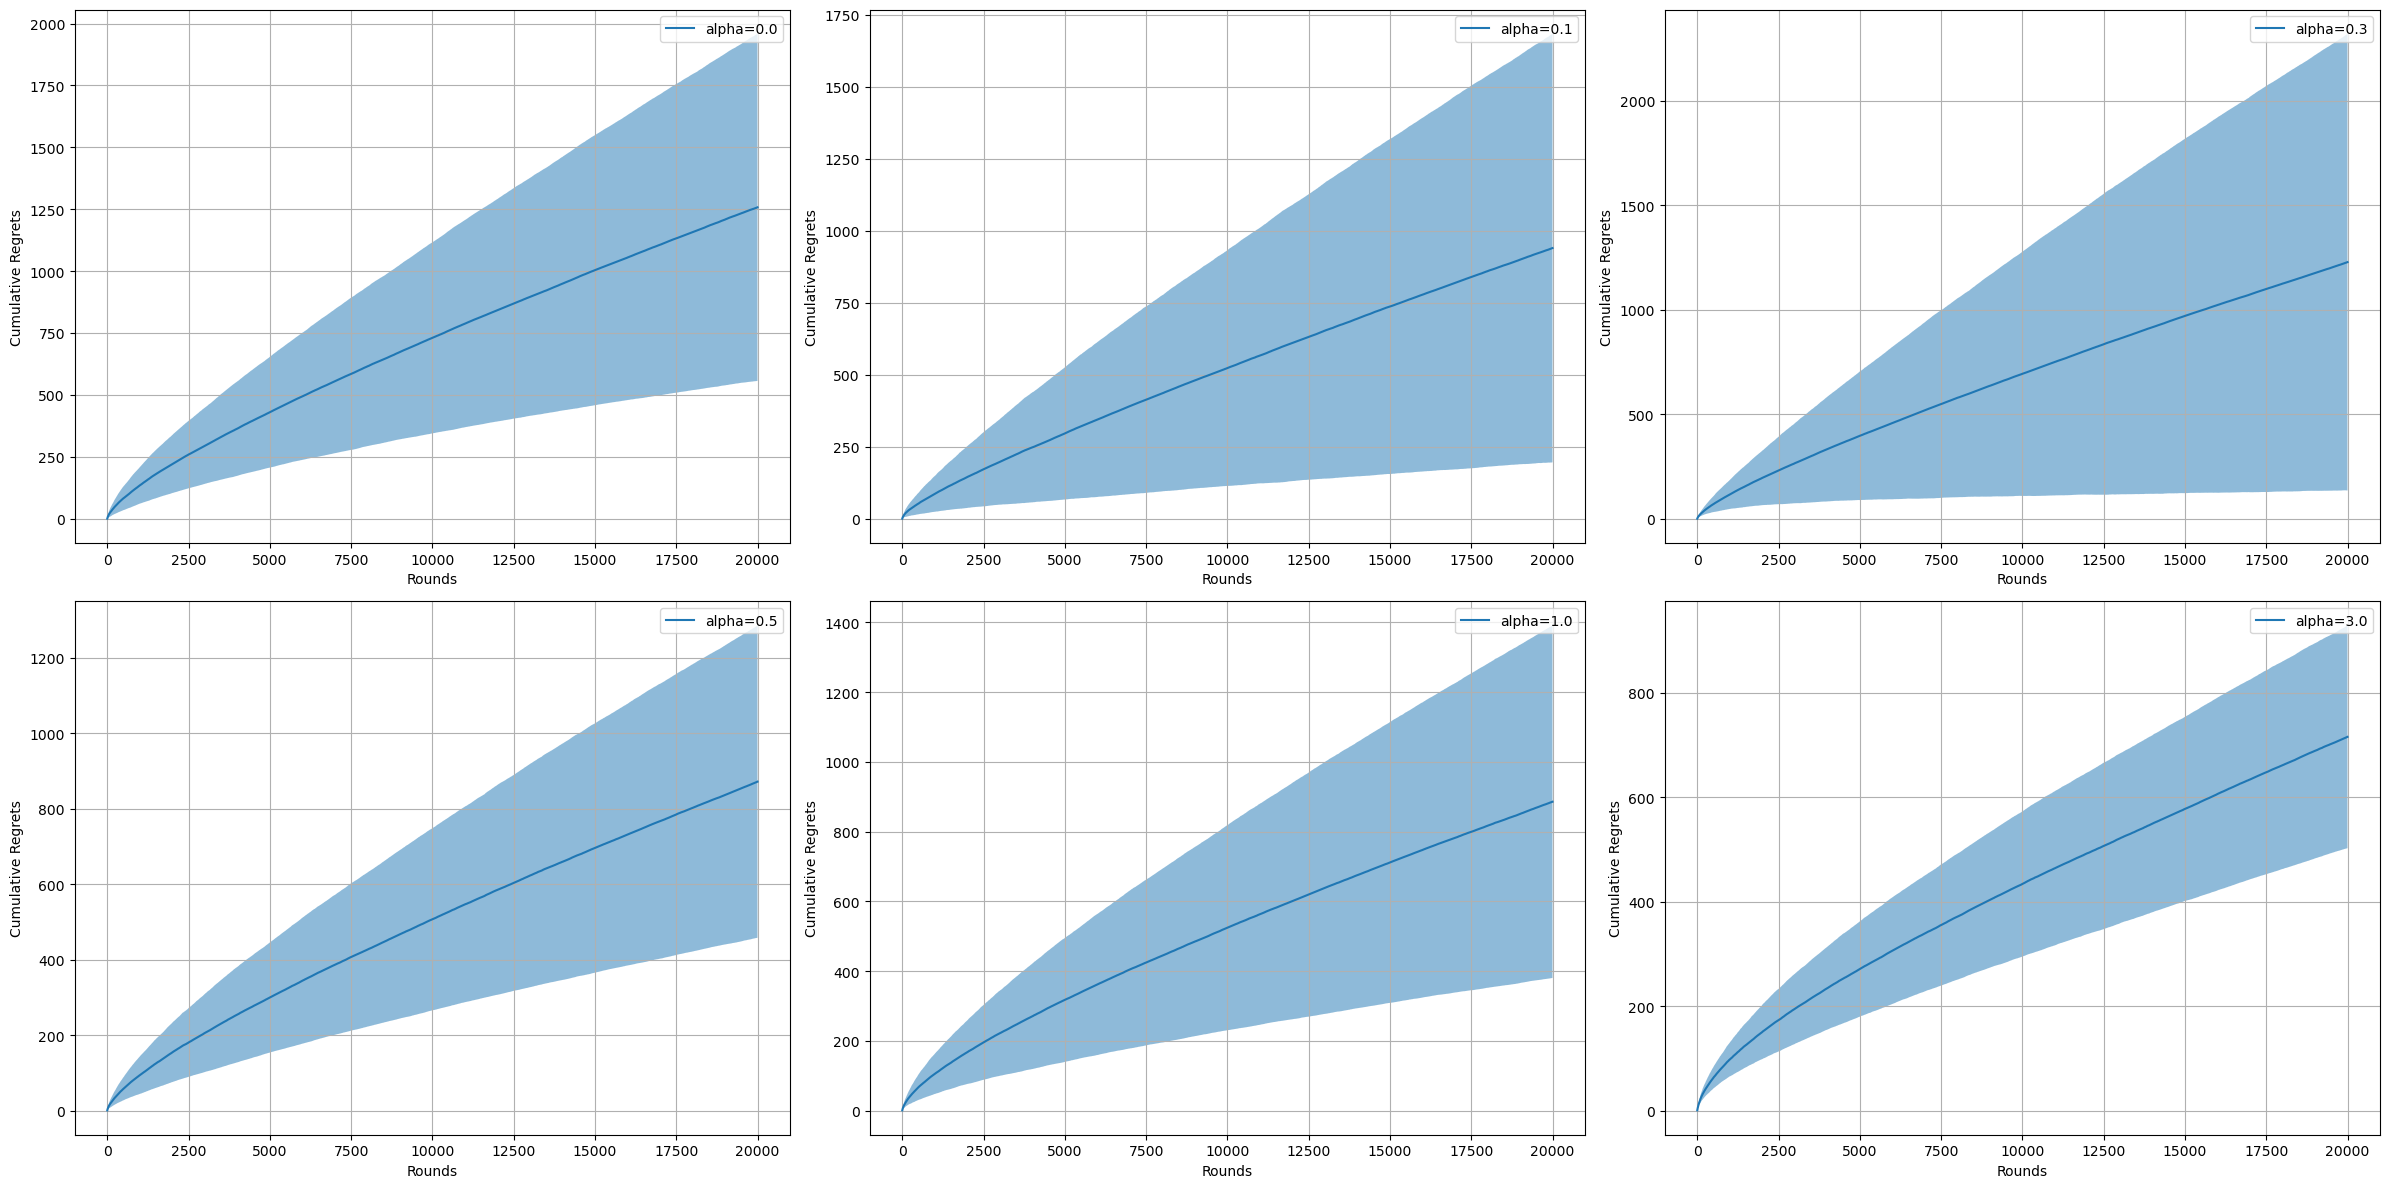

In [34]:
plt.figure(figsize=(24, 12))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"23{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

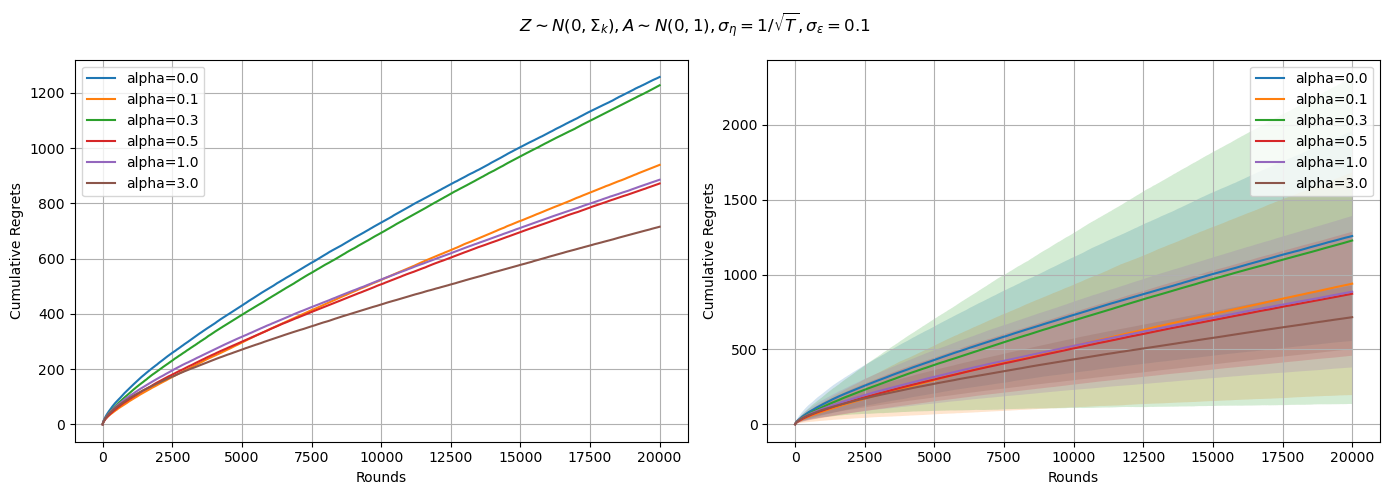

In [35]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.suptitle(f"$Z \sim N(0, \Sigma_k), A\sim N(0,1), \sigma_\eta=1/\sqrt{{T}}, \sigma_\epsilon={reward_noise}$")
plt.tight_layout()
plt.show()

#### $\sigma_\epsilon = 0.5$ (High noise variance)

In [36]:
reward_noise = 0.5

In [37]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=False, map_dist="gaussian",
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=seed+trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6159.83it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6162.08it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6143.30it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6226.52it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6233.84it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6113.26it/s]


Trial 1
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6112.59it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6233.64it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6182.36it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6098.70it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6048.90it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6018.18it/s]


Trial 2
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5942.94it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6128.69it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6046.98it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6209.42it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6079.49it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6026.58it/s]


Trial 3
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6018.56it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6099.48it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6099.01it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6044.99it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6011.25it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6050.88it/s]


Trial 4
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6101.40it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6195.30it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6158.84it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6062.55it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6202.40it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6147.13it/s]


Trial 5
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6171.36it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6103.03it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6218.17it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6093.84it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6163.55it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6122.66it/s]


Trial 6
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6119.73it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6137.91it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6244.92it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6138.02it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6188.45it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6183.68it/s]


Trial 7
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6122.59it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6250.50it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6304.80it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6194.73it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6149.12it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6202.02it/s]


Trial 8
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6116.16it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6186.55it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6150.91it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6240.89it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6236.07it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6242.80it/s]


Trial 9
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6141.56it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6242.95it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6282.52it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6241.17it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6262.26it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6227.19it/s]


In [38]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([6.63941509e-01, 1.44499706e+00, 2.29949914e+00, ...,
       4.96687849e+03, 4.96711816e+03, 4.96721794e+03]), array([2.96142113e-01, 4.71232700e-01, 5.80340200e-01, ...,
       3.57943864e+03, 3.57974535e+03, 3.58006826e+03]), array([0.00000000e+00, 0.00000000e+00, 3.17024250e-01, ...,
       1.00567113e+03, 1.00567113e+03, 1.00567113e+03]), array([1.00000000e+00, 1.87695233e+00, 2.66279034e+00, ...,
       4.49951868e+03, 4.49959424e+03, 4.49967366e+03]), array([3.73292176e-02, 4.67887315e-01, 9.71597994e-01, ...,
       1.95239289e+03, 1.95279626e+03, 1.95300793e+03]), array([1.02164287e-02, 2.33949811e-01, 5.16286714e-01, ...,
       2.19515368e+03, 2.19515368e+03, 2.19515368e+03]), array([8.92103001e-01, 1.89210300e+00, 2.89210300e+00, ...,
       8.82522562e+03, 8.82553205e+03, 8.82563866e+03]), array([9.90345424e-01, 1.95864234e+00, 2.92612190e+00, ...,
       8.81006241e+03, 8.81028275e+03, 8.81052386e+03]), array([3.61803204e-02, 2.4552

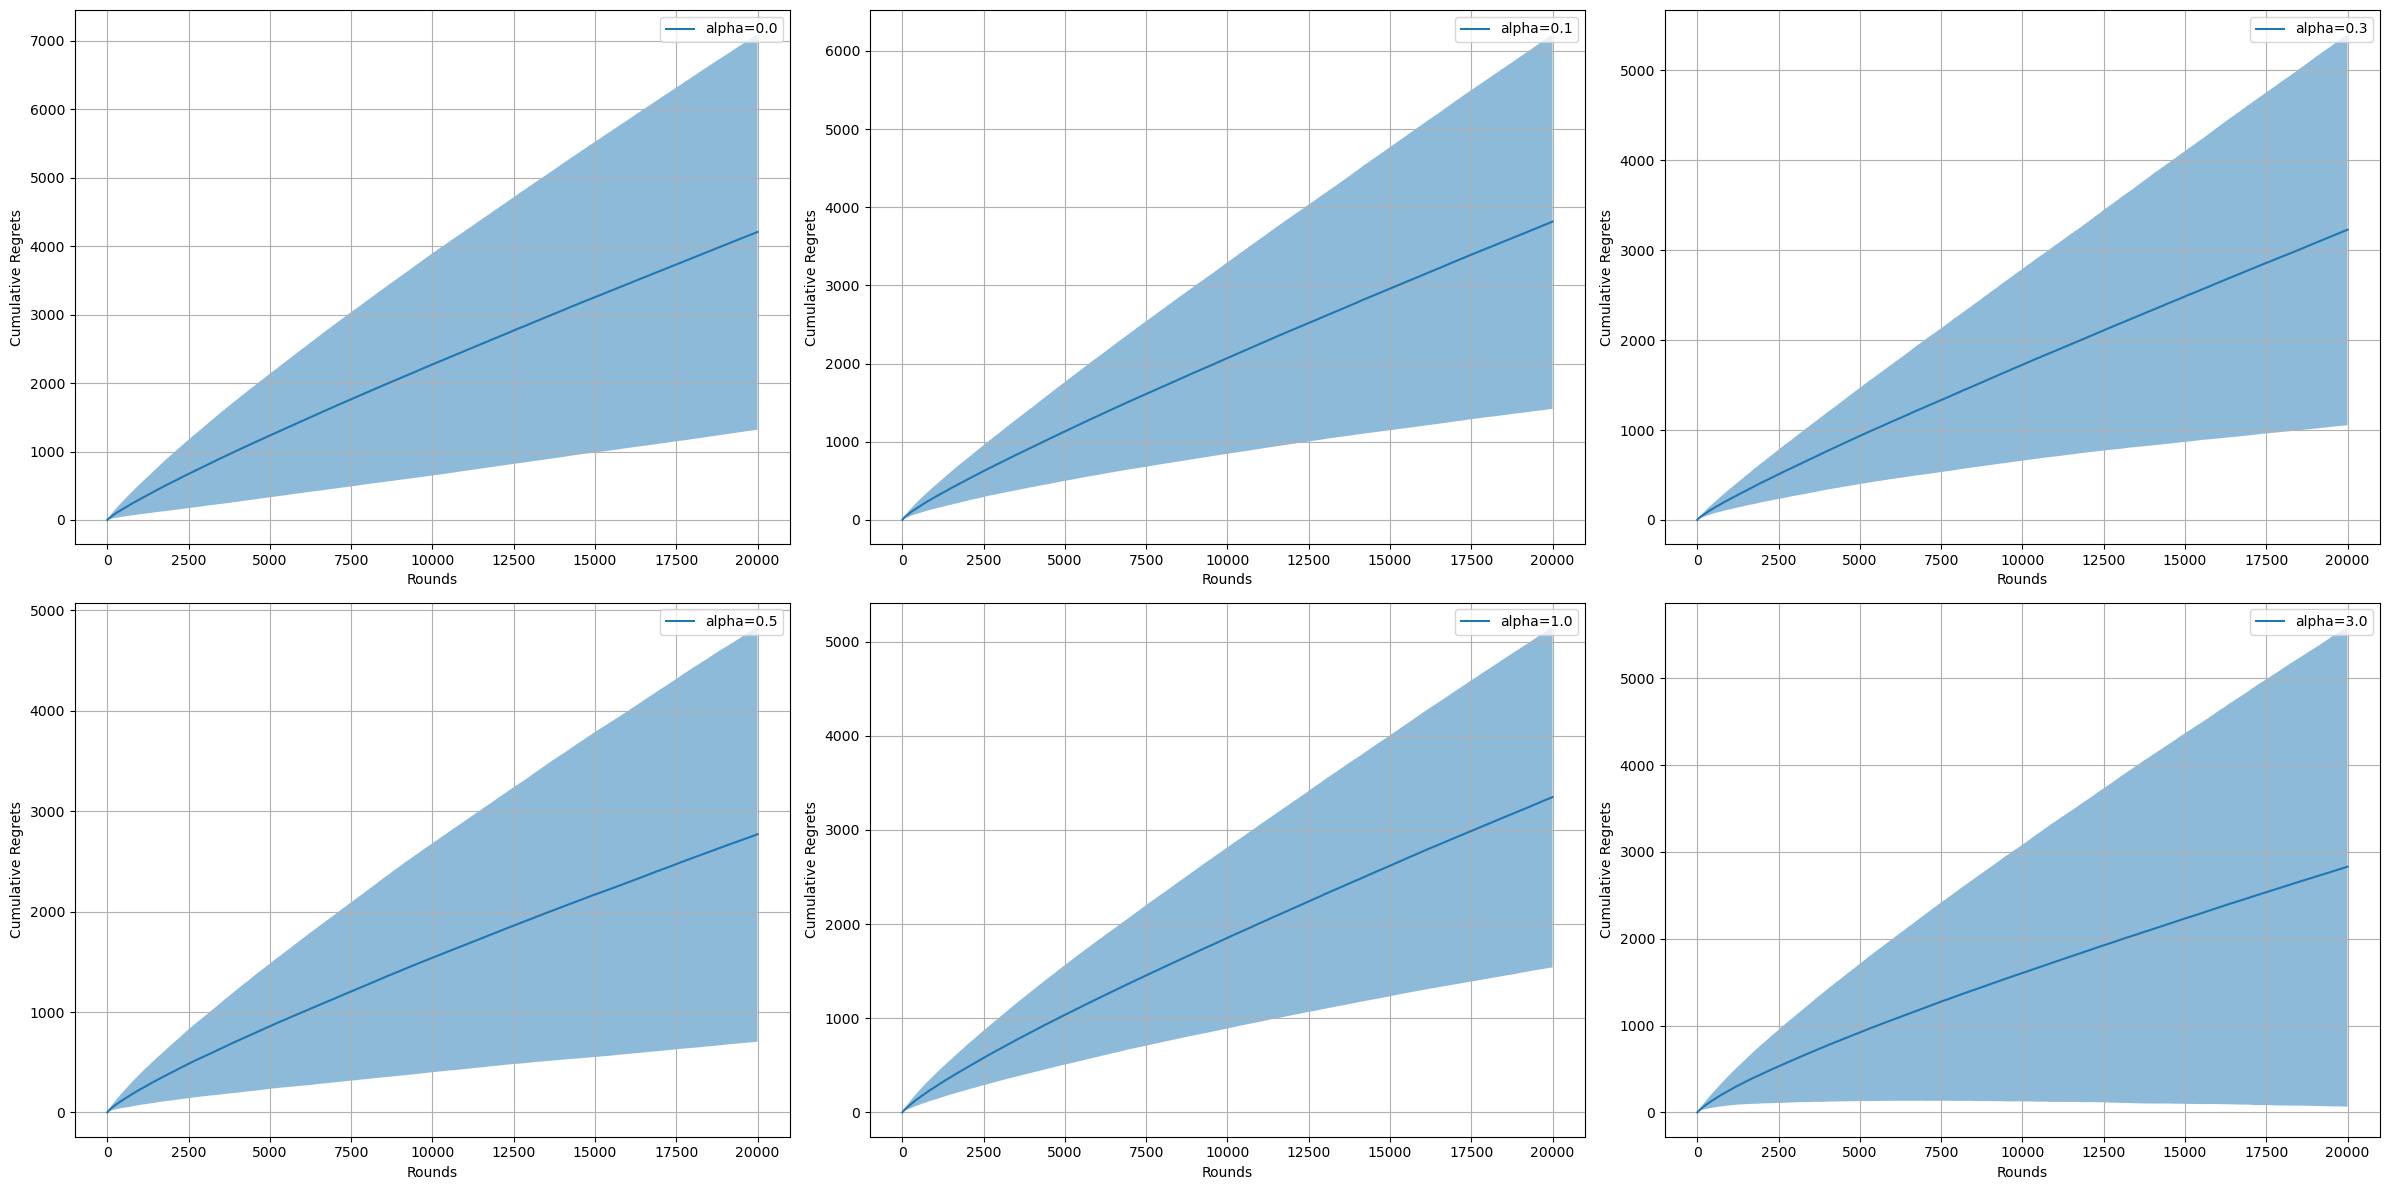

In [39]:
plt.figure(figsize=(24, 12))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"23{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

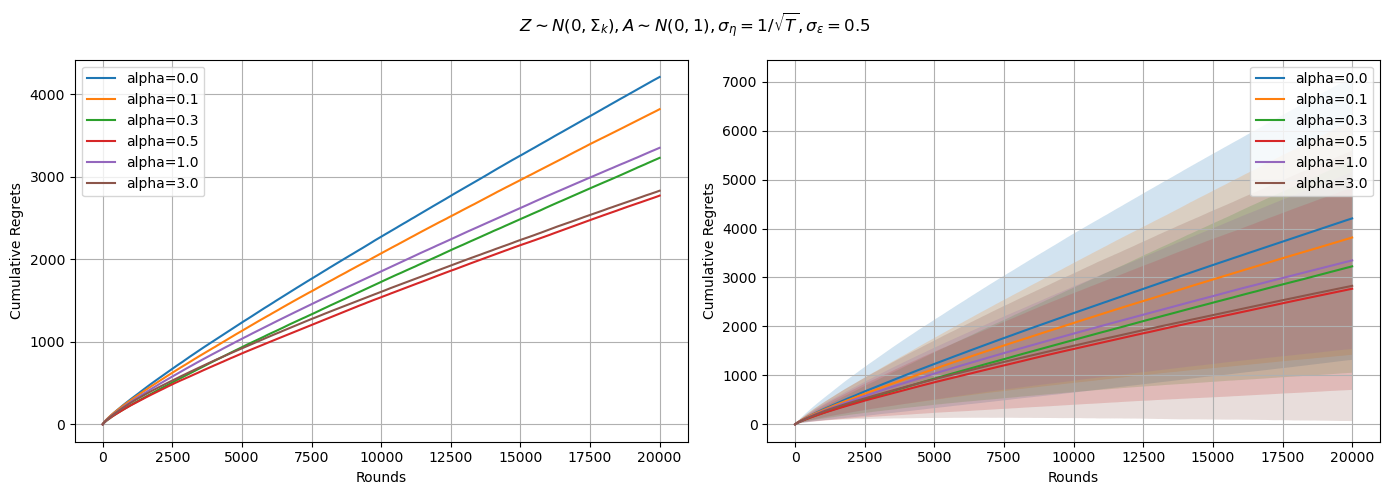

In [40]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.suptitle(f"$Z \sim N(0, \Sigma_k), A\sim N(0,1), \sigma_\eta=1/\sqrt{{T}}, \sigma_\epsilon={reward_noise}$")
plt.tight_layout()
plt.show()

### Latent mapping $\sim$ Uniform

#### $\sigma_\epsilon = 0.1$ (Low noise variance)

In [41]:
reward_noise = 0.1

In [42]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=False, map_dist="uniform",
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=seed+trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6107.01it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6116.77it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6056.34it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6122.02it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6140.42it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6085.76it/s]


Trial 1
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6122.01it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6149.11it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6159.64it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6065.53it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6042.79it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6030.53it/s]


Trial 2
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5943.45it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6042.56it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 5997.70it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6014.57it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5989.48it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6145.32it/s]


Trial 3
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6097.36it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 5974.70it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6091.08it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6175.85it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6197.01it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6145.81it/s]


Trial 4
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6034.45it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6122.07it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6123.88it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6197.18it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6130.01it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6143.02it/s]


Trial 5
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6021.89it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6046.38it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6099.56it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6166.47it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5976.90it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6159.59it/s]


Trial 6
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5963.41it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6090.83it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6079.45it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6113.14it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6016.99it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6113.02it/s]


Trial 7
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6000.61it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6076.41it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6225.72it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6203.00it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6143.11it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5953.91it/s]


Trial 8
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6148.20it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6182.89it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6196.02it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6237.13it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6087.55it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6122.57it/s]


Trial 9
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:04<00:00, 4982.31it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6179.41it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6049.50it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6148.82it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6160.61it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6035.90it/s]


In [43]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([2.48928510e-01, 5.66401968e-01, 7.89133916e-01, ...,
       1.38044629e+03, 1.38044629e+03, 1.38044629e+03]), array([7.09451770e-01, 1.08643352e+00, 1.71063291e+00, ...,
       1.87528915e+03, 1.87541047e+03, 1.87541047e+03]), array([9.34813757e-01, 1.75388712e+00, 1.97849093e+00, ...,
       1.28234534e+03, 1.28234534e+03, 1.28250697e+03]), array([1.00000000e+00, 2.00000000e+00, 2.82895748e+00, ...,
       3.32944403e+03, 3.32970091e+03, 3.32993626e+03]), array([2.44598339e-02, 2.41641500e-01, 5.69848009e-01, ...,
       7.90727444e+02, 7.90759699e+02, 7.90766586e+02]), array([  0.21650355,   0.66567698,   0.70466843, ..., 176.79171146,
       176.79171146, 176.79171146]), array([  0.86495639,   1.59276324,   2.09228257, ..., 366.97624328,
       366.97624328, 366.97624328]), array([  0.40755902,   0.60411561,   0.74072737, ..., 254.18067612,
       254.18067612, 254.18067612]), array([  1.        ,   1.87522508,   2.87522508, ..., 664.5483909

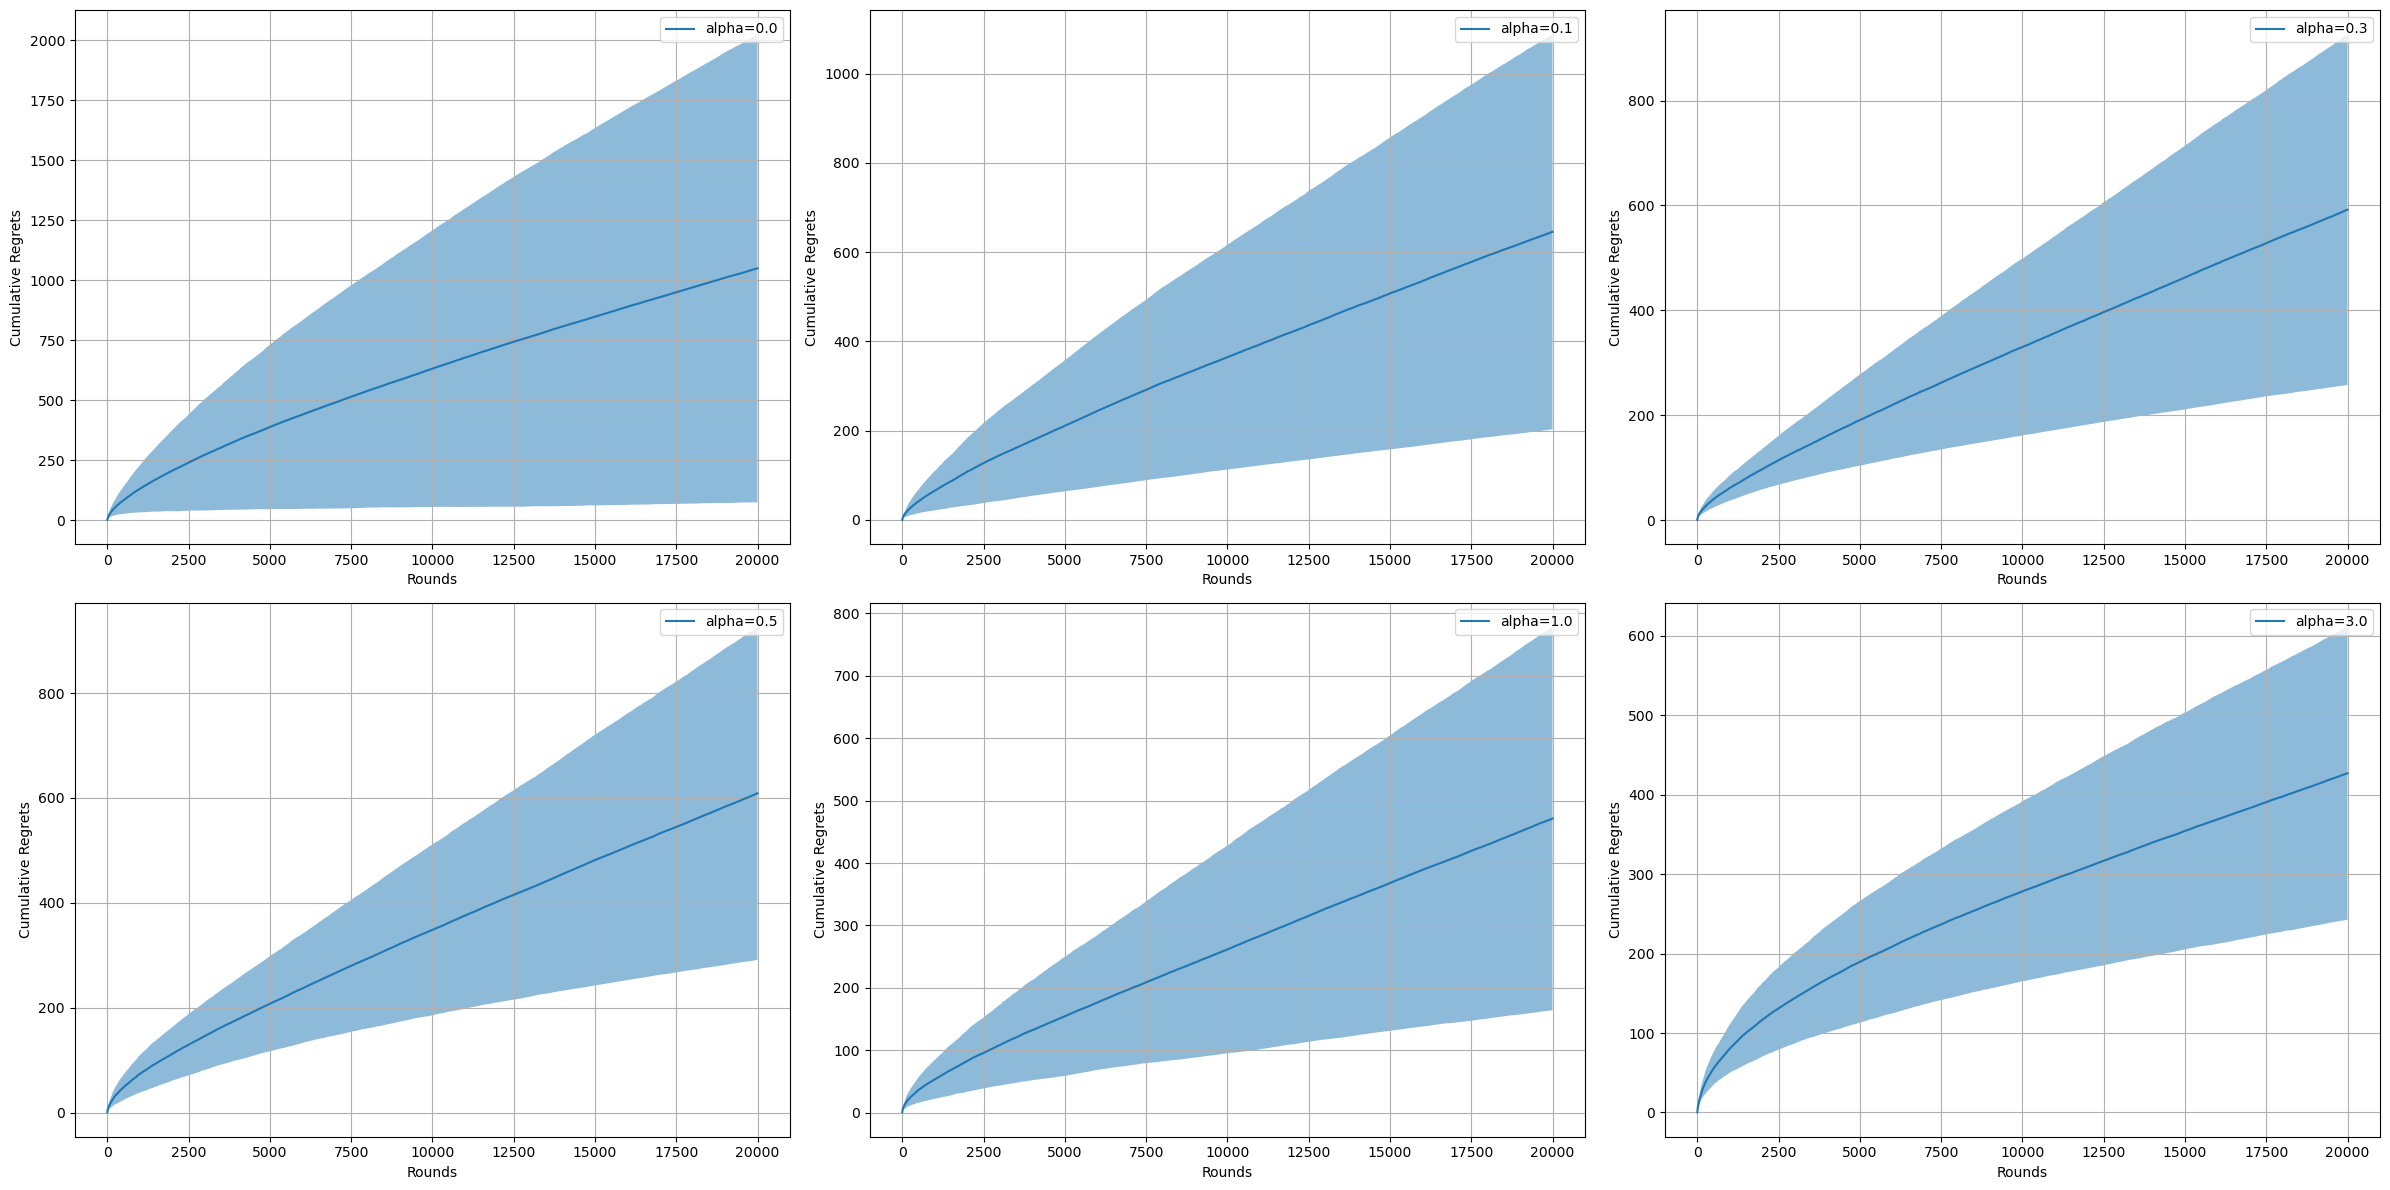

In [44]:
plt.figure(figsize=(24, 12))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"23{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

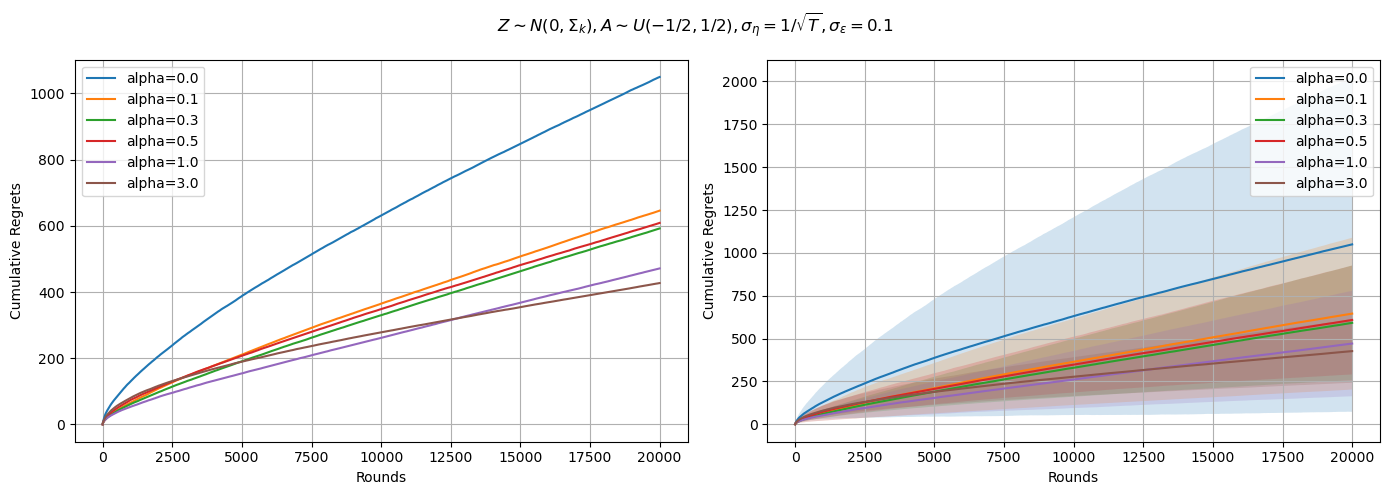

In [45]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.suptitle(f"$Z \sim N(0, \Sigma_k), A\sim U(-1/2, 1/2), \sigma_\eta=1/\sqrt{{T}}, \sigma_\epsilon={reward_noise}$")
plt.tight_layout()
plt.show()

#### $\sigma_\epsilon = 0.5$ (High noise variance)

In [46]:
reward_noise = 0.5

In [47]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, num_actions=N, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=False, map_dist="uniform",
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", alphas=ALPHAS, seed=seed+trial)
    results.append(regret_result)

Trial 0
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6052.22it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6122.53it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6035.91it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6055.15it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6113.57it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6129.00it/s]


Trial 1
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6197.59it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6159.53it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6141.82it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6144.86it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6214.60it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6159.80it/s]


Trial 2
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6173.28it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6130.11it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6113.45it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6130.62it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6117.21it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 5973.93it/s]


Trial 3
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6140.32it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6107.21it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6152.97it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6180.59it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6109.19it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6117.06it/s]


Trial 4
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6056.43it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6196.39it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6179.39it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6211.81it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6187.79it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6132.66it/s]


Trial 5
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6046.62it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6001.17it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6007.60it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6033.41it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6168.73it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6233.77it/s]


Trial 6
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6150.45it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6198.27it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6101.87it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6245.54it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6160.43it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6165.18it/s]


Trial 7
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6111.13it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6197.85it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6181.11it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6192.23it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6235.95it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6218.02it/s]


Trial 8
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6148.91it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6198.77it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6230.83it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6181.62it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6154.83it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6025.28it/s]


Trial 9
=====================alpha=0.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6204.88it/s]


=====================alpha=0.1=====================


100%|██████████| 20000/20000 [00:03<00:00, 6195.77it/s]


=====================alpha=0.3=====================


100%|██████████| 20000/20000 [00:03<00:00, 6266.72it/s]


=====================alpha=0.5=====================


100%|██████████| 20000/20000 [00:03<00:00, 6100.45it/s]


=====================alpha=1.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6160.95it/s]


=====================alpha=3.0=====================


100%|██████████| 20000/20000 [00:03<00:00, 6216.57it/s]


In [48]:
alpha_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        alpha_dict[key].append(np.cumsum(val))
        
print(alpha_dict)

defaultdict(<class 'list'>, {0.0: [array([2.48928510e-01, 5.66401968e-01, 7.89133916e-01, ...,
       2.98668766e+03, 2.98668766e+03, 2.98692973e+03]), array([7.09451770e-01, 1.08643352e+00, 1.71063291e+00, ...,
       8.90514531e+03, 8.90586564e+03, 8.90644794e+03]), array([9.34813757e-01, 1.75388712e+00, 1.97849093e+00, ...,
       4.40036093e+03, 4.40036093e+03, 4.40052256e+03]), array([1.00000000e+00, 2.00000000e+00, 2.82895748e+00, ...,
       9.24870565e+03, 9.24914411e+03, 9.24963148e+03]), array([2.44598339e-02, 2.41641500e-01, 5.69848009e-01, ...,
       2.00400887e+03, 2.00403143e+03, 2.00403933e+03]), array([2.16503548e-01, 6.65676976e-01, 7.04668425e-01, ...,
       3.95691565e+02, 3.95691565e+02, 3.95691565e+02]), array([8.64956385e-01, 1.59276324e+00, 2.09228257e+00, ...,
       6.22378352e+03, 6.22404188e+03, 6.22420011e+03]), array([4.07559016e-01, 6.04115608e-01, 7.40727369e-01, ...,
       1.22540443e+03, 1.22540443e+03, 1.22540443e+03]), array([1.00000000e+00, 1.8752

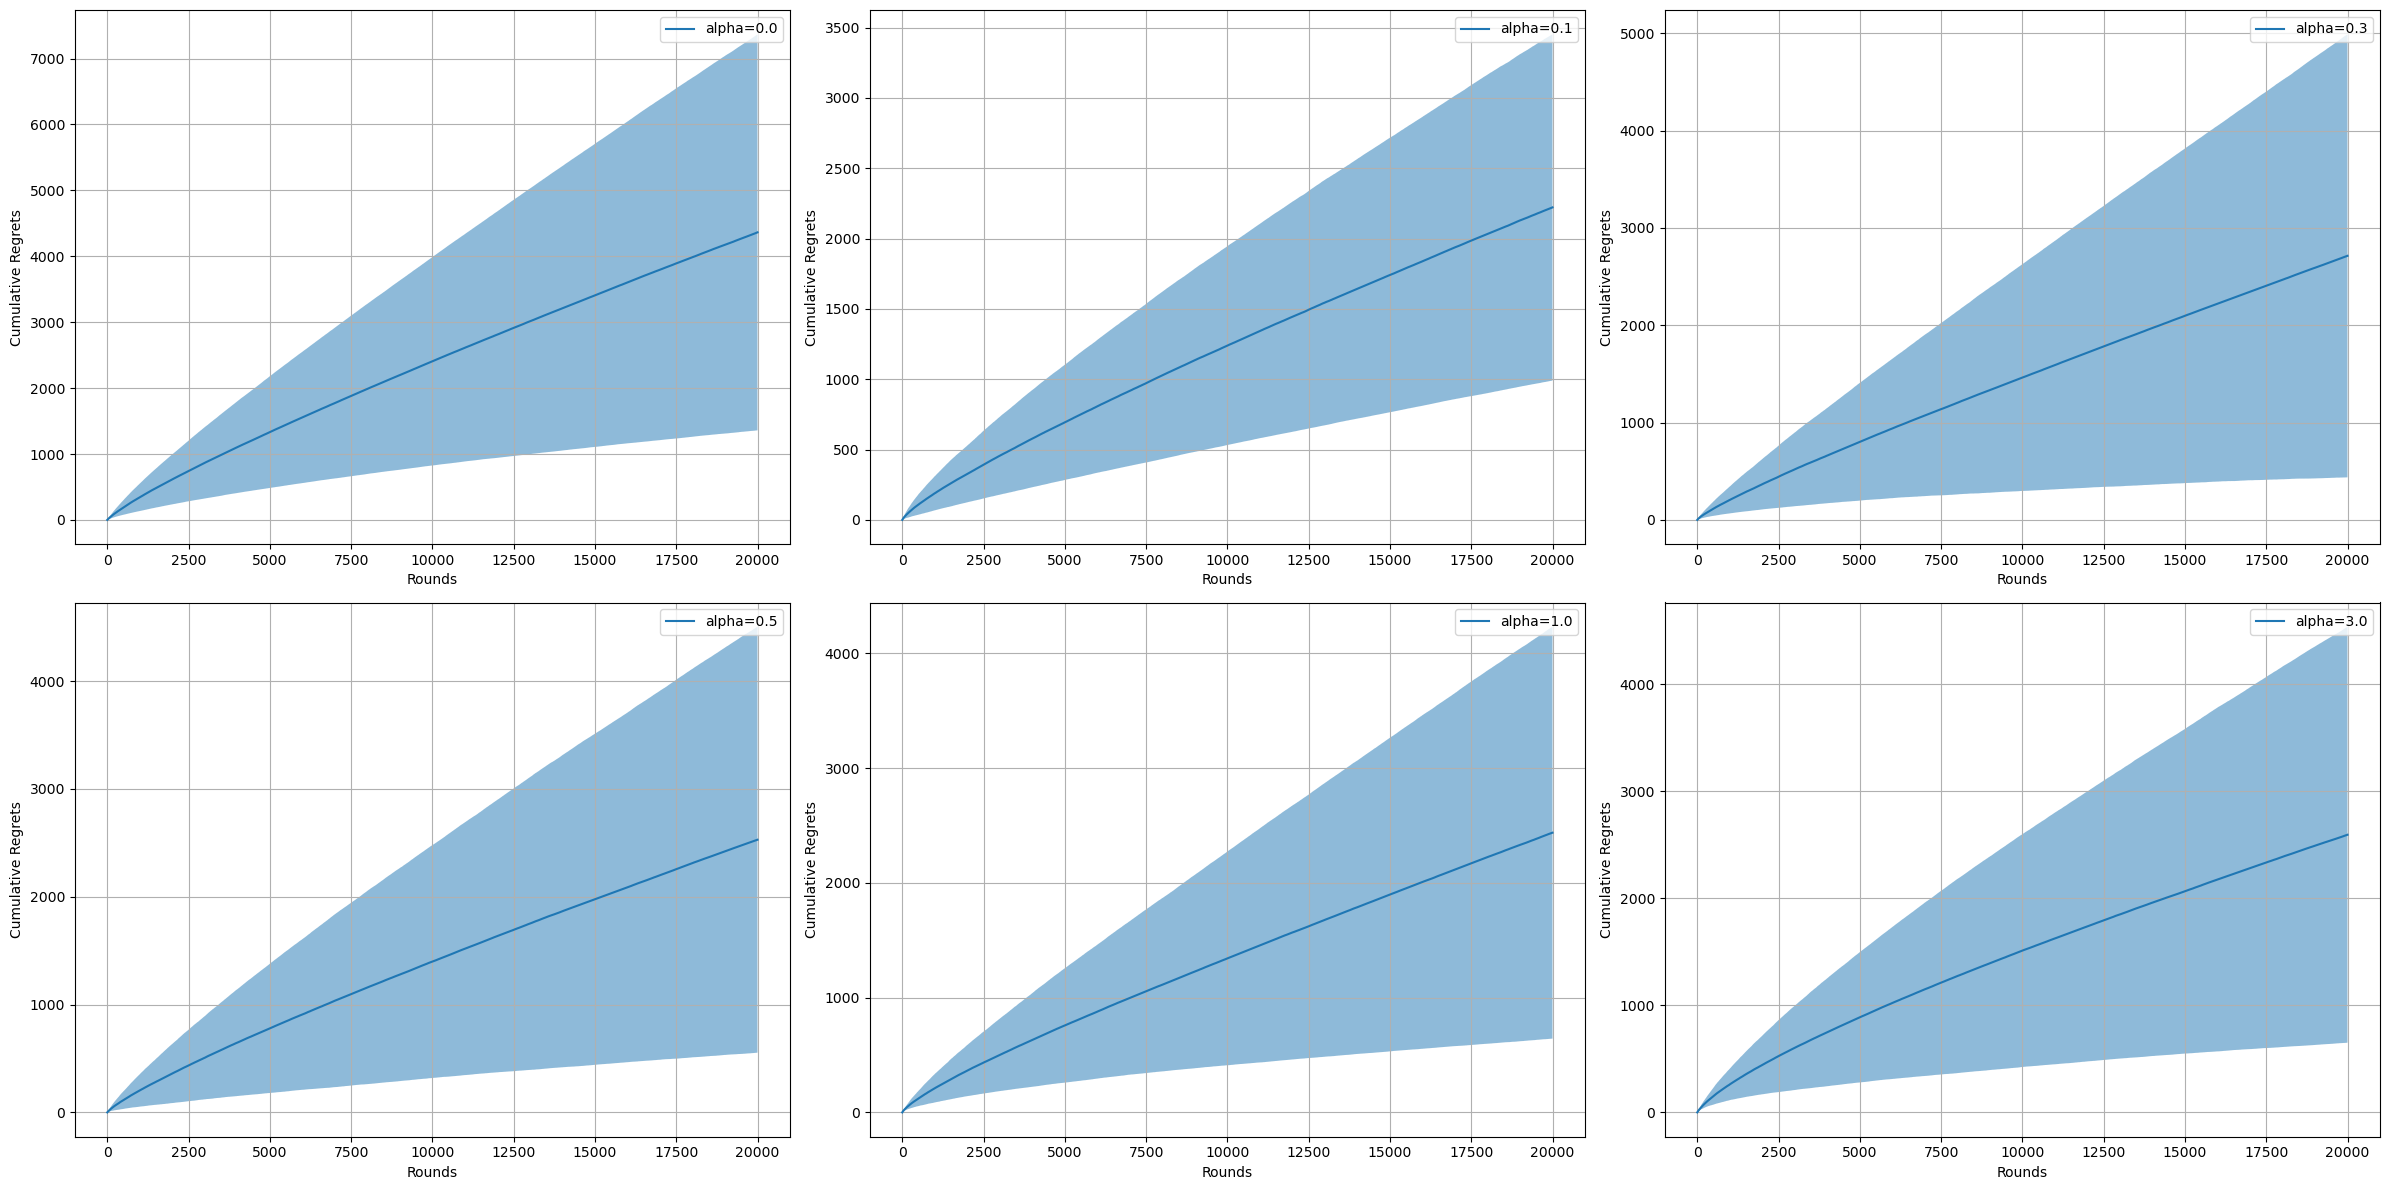

In [49]:
plt.figure(figsize=(24, 12))
for i, alpha in enumerate(alpha_dict.keys()):
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    
    plt.subplot(int(f"23{i+1}"))
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.5)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()

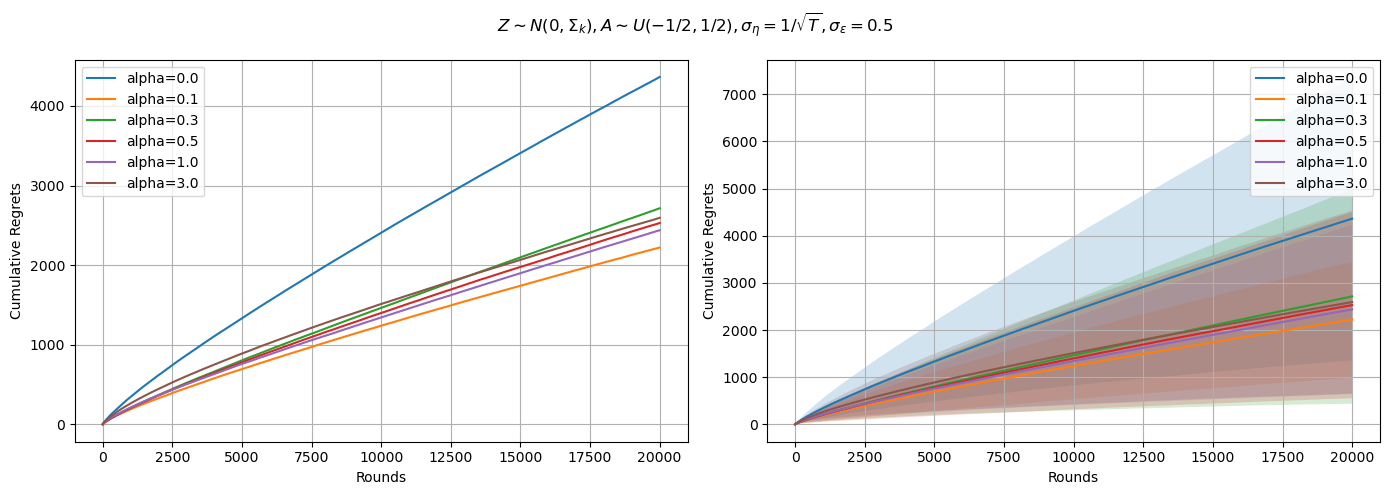

In [50]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    plt.plot(mean, label=f"alpha={alpha}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.subplot(122)
for alpha in alpha_dict.keys():
    mean = np.array(alpha_dict[alpha]).mean(axis=0)
    std = np.array(alpha_dict[alpha]).std(axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={alpha}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

plt.suptitle(f"$Z \sim N(0, \Sigma_k), A\sim U(-1/2, 1/2), \sigma_\eta=1/\sqrt{{T}}, \sigma_\epsilon={reward_noise}$")
plt.tight_layout()
plt.show()

# Masked Latent Features

## $d=16, k=12, 0\le N \le 12$

In [11]:
def run(agent:LinUCB, horizon:int, action_space:int, num_actions:int, observables:np.ndarray, reward_bound:float,
        latents:np.ndarray, reward_param:np.ndarray, reward:np.ndarray, use_tqdm:bool=True, verbose:bool=False):
    
    if use_tqdm:
        bar = tqdm(range(horizon))
    else:
        bar = range(horizon)
        
    regrets = np.zeros(horizon)
        
    for t in bar:
        indices = np.random.randint(0, action_space, num_actions) # sample action set for each round
        action_set, reward_set, latent_set = observables[indices], reward[indices], latents[indices]
        
        ## masking
        masked_dim, latent_dim = latent_set.shape # masked_dim == num_actions
        unmasked_dim = latent_dim - masked_dim
        latent_set = latent_set[:, :unmasked_dim]
        reward_param = reward_param[:unmasked_dim]
#         print(latent_set.shape)
        latent_set = np.concatenate((latent_set, np.identity(masked_dim)), axis=1) # [z_1, ..., z_{k-l}, 1, 0, ..., 0]
        reward_param = np.concatenate((reward_param, np.random.randn(masked_dim)), axis=0)
        
        ## compute optimal reward and optimal action
        exp_rewards = latent_set @ reward_param     # (N, ) expected rewards
        optimal_action = np.argmax(exp_rewards)
        optimal_reward = exp_rewards[optimal_action]
        
        ## choose the best action
        chosen_arm = agent.choose(action_set)    # index in the action set
        chosen_context = action_set[chosen_arm]
        
        ## observe the reward
        chosen_reward = reward_set[chosen_arm]
        
        ## compute the regret
        instance_regret = optimal_reward - exp_rewards[chosen_arm]
#         print(instance_regret)
        regrets[t] = instance_regret
        
        ## update the agent
        agent.update(chosen_context, chosen_reward)
        
        if verbose: 
            print(f"round {t+1}, optimal action : {optimal_action}, optimal reward : {optimal_reward:.3f}, chosen action : {chosen_arm}")
            print(f"\trealized reward : {chosen_reward:.3f}, expected reward: {exp_rewards[chosen_arm]:.3f}, regret : {instance_regret:.3f}, cum.regret : {np.sum(regrets):.3f}")
            
    return regrets

In [15]:
## hyper-parameters
M = 50000         # number of samples
N = 20            # number of actions in the action set at each round
d = 16            # observable dimension
k = 12             # latent dimension
T = 20000         # total time horizon

feature_bound = 1.
matrix_lower_bound = 1.  # bound of the encoder
matrix_upper_bound = 2.
param_bound = 1.
reward_bound = 1.
seed = 2001

reward_noise = 0.1
alpha = 1.0
run_time = 10

In [16]:
# end-to-end runner
def end2end(num_samples:int, d:int, k:int, ctx_noise:float, reward_noise:float, 
            disjoint:bool, bounds:list, reward_dist:str, seed:int, use_tqdm:bool=True, 
            verbose:bool=False, map_dist:str="gaussian", alpha=alpha):
    feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound = bounds
    decoder, Z, X, context_noise = sampleGenerator(num_samples=num_samples, obs_dim=d, latent_dim=k, 
                                                   noise_var=ctx_noise, feature_bound=feature_bound, 
                                                   matrix_lower_bound=matrix_lower_bound,
                                                   matrix_upper_bound=matrix_upper_bound,
                                                   disjoint=disjoint, seed=seed, map_dist=map_dist)
    
    reward_param = param_generator(dimension=k, distribution=reward_dist, bound=param_bound)
    reward_error, var = subgaussian_noise(distribution="gaussian", size=M, var=reward_noise)
    Y = Z @ reward_param + reward_error
    if reward_bound:
        Y = minmax(Y, bound=reward_bound)
    
    regret_result = {}
    for num in range(1, k+1):
        print(f"======================== Number of arms {num} ========================")
        agent = LinUCB(d=d, alpha=alpha)
        result = run(agent=agent, horizon=T, action_space=num_samples, num_actions=num, 
                     observables=X, latents=Z, reward_param=reward_param, reward=Y, 
                     use_tqdm=use_tqdm, verbose=verbose, reward_bound=reward_bound)
        regret_result[num] = result
    
    return regret_result

In [17]:
results = []
for trial in range(run_time):
    print(f"Trial {trial}")
    regret_result = end2end(num_samples=M, d=d, k=k, ctx_noise=(1 / np.sqrt(T)), 
                            reward_noise=reward_noise, disjoint=False, map_dist="uniform",
                            bounds=[feature_bound, matrix_lower_bound, matrix_upper_bound, param_bound, reward_bound], 
                            reward_dist="gaussian", seed=seed+trial, alpha=alpha)
    results.append(regret_result)

Trial 0
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2238.92it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2290.80it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2285.11it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2316.93it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2304.20it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2300.64it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2294.20it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2291.64it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2273.00it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2273.91it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2284.55it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2266.28it/s]


Trial 1
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2330.61it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2338.74it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2335.04it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2329.37it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2322.07it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2320.26it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2310.84it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2308.82it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2306.18it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2299.75it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2285.64it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2260.12it/s]


Trial 2
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2250.70it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2267.60it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2262.17it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2254.21it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2269.64it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2273.68it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2263.88it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2264.38it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2279.66it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2271.86it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2296.06it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2273.04it/s]


Trial 3
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2257.37it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2262.35it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2264.36it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2260.82it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2259.56it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2252.47it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2251.67it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2243.10it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2255.00it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2250.34it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2261.81it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2229.83it/s]


Trial 4
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2280.02it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2284.93it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2280.85it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2306.97it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2272.06it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2296.86it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2264.39it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2284.78it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2272.74it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2292.13it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2295.28it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2293.24it/s]


Trial 5
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2268.09it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2271.85it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2307.45it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2286.34it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2301.89it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2273.45it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2276.21it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2267.08it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2287.74it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2256.49it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2293.07it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2284.47it/s]


Trial 6
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2277.58it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2303.23it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2303.24it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2303.95it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2300.69it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2295.44it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2285.77it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2284.93it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2269.07it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2252.40it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2288.68it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2256.75it/s]


Trial 7
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2311.45it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2311.41it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2303.68it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2297.95it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2287.99it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2291.65it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2285.50it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2280.69it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2267.94it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2253.87it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2281.32it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2277.98it/s]


Trial 8
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2323.23it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2324.20it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2318.34it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2316.52it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2320.06it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2304.58it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2283.19it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2276.27it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2277.66it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2268.20it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2252.66it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2254.54it/s]


Trial 9
======================== Number of arms 1 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2336.72it/s]


======================== Number of arms 2 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2332.49it/s]


======================== Number of arms 3 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2329.89it/s]


======================== Number of arms 4 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2319.35it/s]


======================== Number of arms 5 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2316.91it/s]


======================== Number of arms 6 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2312.60it/s]


======================== Number of arms 7 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2302.51it/s]


======================== Number of arms 8 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2293.54it/s]


======================== Number of arms 9 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2294.66it/s]


======================== Number of arms 10 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2268.85it/s]


======================== Number of arms 11 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2237.07it/s]


======================== Number of arms 12 ========================


100%|██████████| 20000/20000 [00:08<00:00, 2228.53it/s]


In [18]:
print(results[0])

{1: array([0., 0., 0., ..., 0., 0., 0.]), 2: array([0.        , 1.0151658 , 2.35109145, ..., 0.        , 0.        ,
       0.        ]), 3: array([0.85130712, 2.00912918, 0.        , ..., 0.        , 0.        ,
       0.319795  ]), 4: array([0.89584307, 1.15356155, 0.        , ..., 0.45046602, 0.63905918,
       0.        ]), 5: array([1.46058233, 1.01627156, 1.26732797, ..., 0.        , 0.44985032,
       0.        ]), 6: array([1.55602876, 0.        , 0.58218206, ..., 2.8985537 , 0.55896456,
       1.47644418]), 7: array([1.92143943, 2.17205377, 1.73672404, ..., 0.        , 1.51799859,
       1.20549821]), 8: array([3.00829289, 2.34793494, 2.5459784 , ..., 1.32334749, 3.25276702,
       2.09311605]), 9: array([1.07202337, 0.89485287, 0.        , ..., 2.04420517, 3.38841539,
       2.65570816]), 10: array([2.19795715, 0.91464464, 0.71483439, ..., 1.04130231, 2.54547271,
       2.2750359 ]), 11: array([2.57112791, 1.92449716, 1.87232063, ..., 1.83022256, 0.92858223,
       2.0568616 

In [19]:
arm_dict = defaultdict(list)
for item in results:
    for key, val in item.items():
        arm_dict[key].append(np.cumsum(val))
        
print(arm_dict)

defaultdict(<class 'list'>, {1: [array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])], 2: [array([0.00000000e+00, 1.01516580e+00, 3.36625725e+00, ...,
       9.50986252e+03, 9.50986252e+03, 9.50986252e+03]), array([0.00000000e+00, 1.25777420e+00, 1.25777420e+00, ...,
       9.21582023e+03, 9.21791600e+03, 9.21864071e+03]), array([   0.        ,    0.        ,    0.        , ..., 8285.36324218,
       8285.36324218, 8285.73018594]), array([2.04431127e+00, 2.04431127e+00, 2.04431127e+00, ...,
       1.02270575e+04, 1.02287380e+04, 1.02287380e+04]), array([0.00000000e+00, 9.51905224e-01, 2.87810869e+00, ...,
       9.05326712e+03, 9.05326712e+03, 9.05429551e+03]), arr

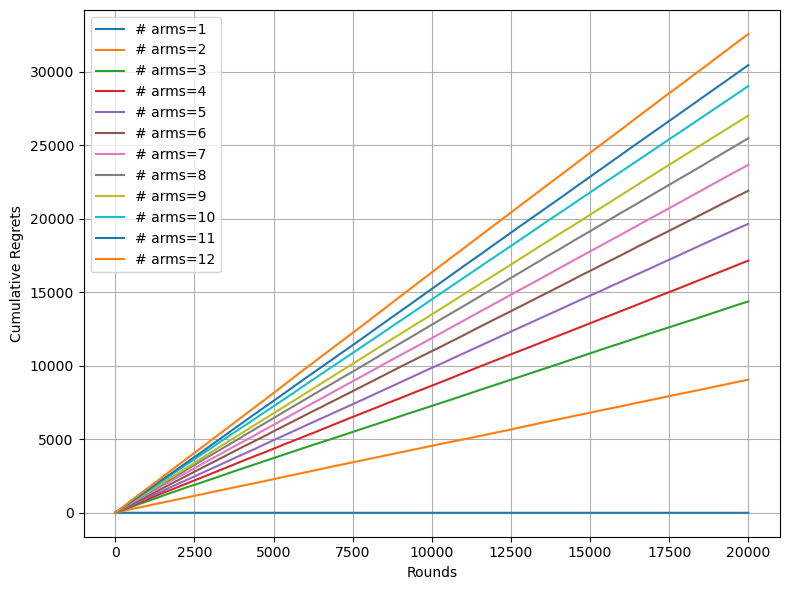

In [21]:
plt.figure(figsize=(8, 6))
# plt.subplot(121)
for arm in arm_dict.keys():
    mean = np.array(arm_dict[arm]).mean(axis=0)
    plt.plot(mean, label=f"# arms={arm}")
plt.grid(True)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regrets")

# plt.subplot(122)
# for arm in arm_dict.keys():
#     mean = np.array(alpha_dict[arm]).mean(axis=0)
#     std = np.array(alpha_dict[arm]).std(axis=0, ddof=1)
#     plt.plot(mean, label=f"# arms={arm}")
#     plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
# plt.grid(True)
# plt.legend()
# plt.xlabel("Rounds")
# plt.ylabel("Cumulative Regrets")
    
plt.tight_layout()
plt.show()